In this notebook I will visualize some of the paintings created, first when only allowing to copy from other populations, and then also allowing in-pop copying.

In [1]:
%run ../scripts/notebook_settings.py
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
recomb_map_path = "/faststorage/project/baboondiversity/data/haploidified_chrX_males/uniform_rec_10cM.recombfile"
idfile_path = "/faststorage/project/baboondiversity/data/haploidified_chrX_males/idfile.ids"

In [3]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def count_paint_windows(pop_dict, spot_df, window):
    end_pos = spot_df.end_pos.values[-1]
    pop_dict["window"] = list(range(end_pos//window+1))
    for window_number in range(end_pos//window+1):
        #Selecting the rows which are inside
        window_start = window*window_number
        window_end = window*(window_number+1)-1
        sub_df = spot_df.loc[(spot_df.end_pos >= window_start)
                    & (spot_df.pos < window_end)]
        total_paint = 0
        for i, row in sub_df.iterrows():
            #When the painting covers the whole window
            if len(sub_df) == 1:
                pop_dict[row["pop"]][window_number] += window
                total_paint += window
            #When the painting started before the window
            elif row.pos < window_start:
                pop_dict[row["pop"]][window_number] += row.end_pos-window_start
                total_paint += row.end_pos-window_start
            #When the painting ends after the window
            elif row.end_pos > window_end:
                pop_dict[row["pop"]][window_number] += window_end-row.pos
                total_paint += window_end-row.pos
            #When the painting is fully in the window
            else:
                pop_dict[row["pop"]][window_number] += row.paint_length
                total_paint += row.paint_length
    return pop_dict

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

In [4]:
#Constant files, the idfile and the recombination map
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map = pd.read_csv(recomb_map_path, sep=" ")
pos_list = recomb_map["start.pos"]

Various implementations

In [5]:
#Variable definition, in the case in which we do not allow in_pop copying.
def create_paint_df_group(pop_inv, window):
    no_inpop_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/{}scaled_rec/chromopaintings/sample{}.samples.out"

    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    pop_dict = {}
    for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
        pop_dict[population] = [0]*(end_pos//window+1)
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index+1] = row["pop"]

    df_l = []
    for i in range(len(idfile.loc[idfile["pop"] == pop_inv])):
        f = open(no_inpop_donor.format(pop_inv, i), "r")
        ad_lines = f.readlines()
        print(i)
        for p_num in range(10):
            paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            sub_dict = count_paint_windows(pop_dict, spot_df, window)
            sub_df = pd.DataFrame(sub_dict)
            sub_df["paint".format(p_num)]=p_num
            sub_df["individual"] = i
            df_l.append(sub_df)
    all_df = pd.concat(df_l)
    all_df = all_df.set_index("window")
    return all_df

def create_paint_df_ind(pop_inv, ind, window):
    no_inpop_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/{}scaled_rec/chromopaintings/sample{}.samples.out"

    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    pop_dict = {}
    for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
        pop_dict[population] = [0]*(end_pos//window+1)
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index+1] = row["pop"]

    df_l = []
    f = open(no_inpop_donor.format(pop_inv, ind), "r")
    ad_lines = f.readlines()
    print(ind)
    for p_num in range(10):
        paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
        single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
        single_p_df = single_p_df.astype(int)
        spot_df = generate_spot_df(single_p_df, map_dict)
        sub_dict = count_paint_windows(pop_dict, spot_df, window)
        sub_df = pd.DataFrame(sub_dict)
        sub_df["paint".format(p_num)]=p_num
        sub_df["individual"] = i
        df_l.append(sub_df)
    all_df = pd.concat(df_l)
    all_df = all_df.set_index("window")
    return all_df

#Allowing for copying in-pop
def create_paint_df_group_allcopy(pop_inv, window):
    all_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/chromopaintings/copy{}.samples.out"

    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    pop_dict = {}
    for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
        pop_dict[population] = [0]*(end_pos//window+1)
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index+1] = row["pop"]

    df_l = []
    for index, row in (idfile.loc[idfile["pop"] == pop_inv]).iterrows():
        i = row.ID_index
        f = open(all_donor.format(i), "r")
        ad_lines = f.readlines()
        print(i)
        for p_num in range(10):
            paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            sub_dict = count_paint_windows(pop_dict, spot_df, window)
            sub_df = pd.DataFrame(sub_dict)
            sub_df["paint".format(p_num)]=p_num
            sub_df["individual"] = i
            df_l.append(sub_df)
    all_df = pd.concat(df_l)
    all_df = all_df.set_index("window")
    return all_df

#Returning spot df to paint fragment lengths - does not allow inpop copying, as that would mask signal.
def painting_spots(pop_inv, ind, window):
    no_inpop_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/{}scaled_rec/chromopaintings/sample{}.samples.out"

    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    pop_dict = {}
    for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
        pop_dict[population] = [0]*(end_pos//window+1)
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index+1] = row["pop"]

    df_l = []
    f = open(no_inpop_donor.format(pop_inv, ind), "r")
    ad_lines = f.readlines()
    print(ind)
    for p_num in range(10):
        paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
        single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
        single_p_df = single_p_df.astype(int)
        spot_df = generate_spot_df(single_p_df, map_dict)
        df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

#Allowing for copying in-pop
def painting_spots_allcopy(pop_inv, window):
    all_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/chromopaintings/copy{}.samples.out"

    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    pop_dict = {}
    for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
        pop_dict[population] = [0]*(end_pos//window+1)
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index+1] = row["pop"]

    df_l = []
    for index, row in (idfile.loc[idfile["pop"] == pop_inv]).iterrows():
        i = row.ID_index
        f = open(all_donor.format(i), "r")
        ad_lines = f.readlines()
        print(i)
        for p_num in range(10):
            paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = i
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [6]:
window = 1000000
def stairs(df, start='start', end='end', pos='pos', endtrim=0, window=window):
    df["start"] = df.index.values*window
    df["end"] = df.index.values*window+window
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Iterating through all population and saving plots of them

0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


FileNotFoundError: [Errno 2] No such file or directory: '/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/Hamadryas_Ethiopiascaled_rec/chromopaintings/sample19.samples.out'

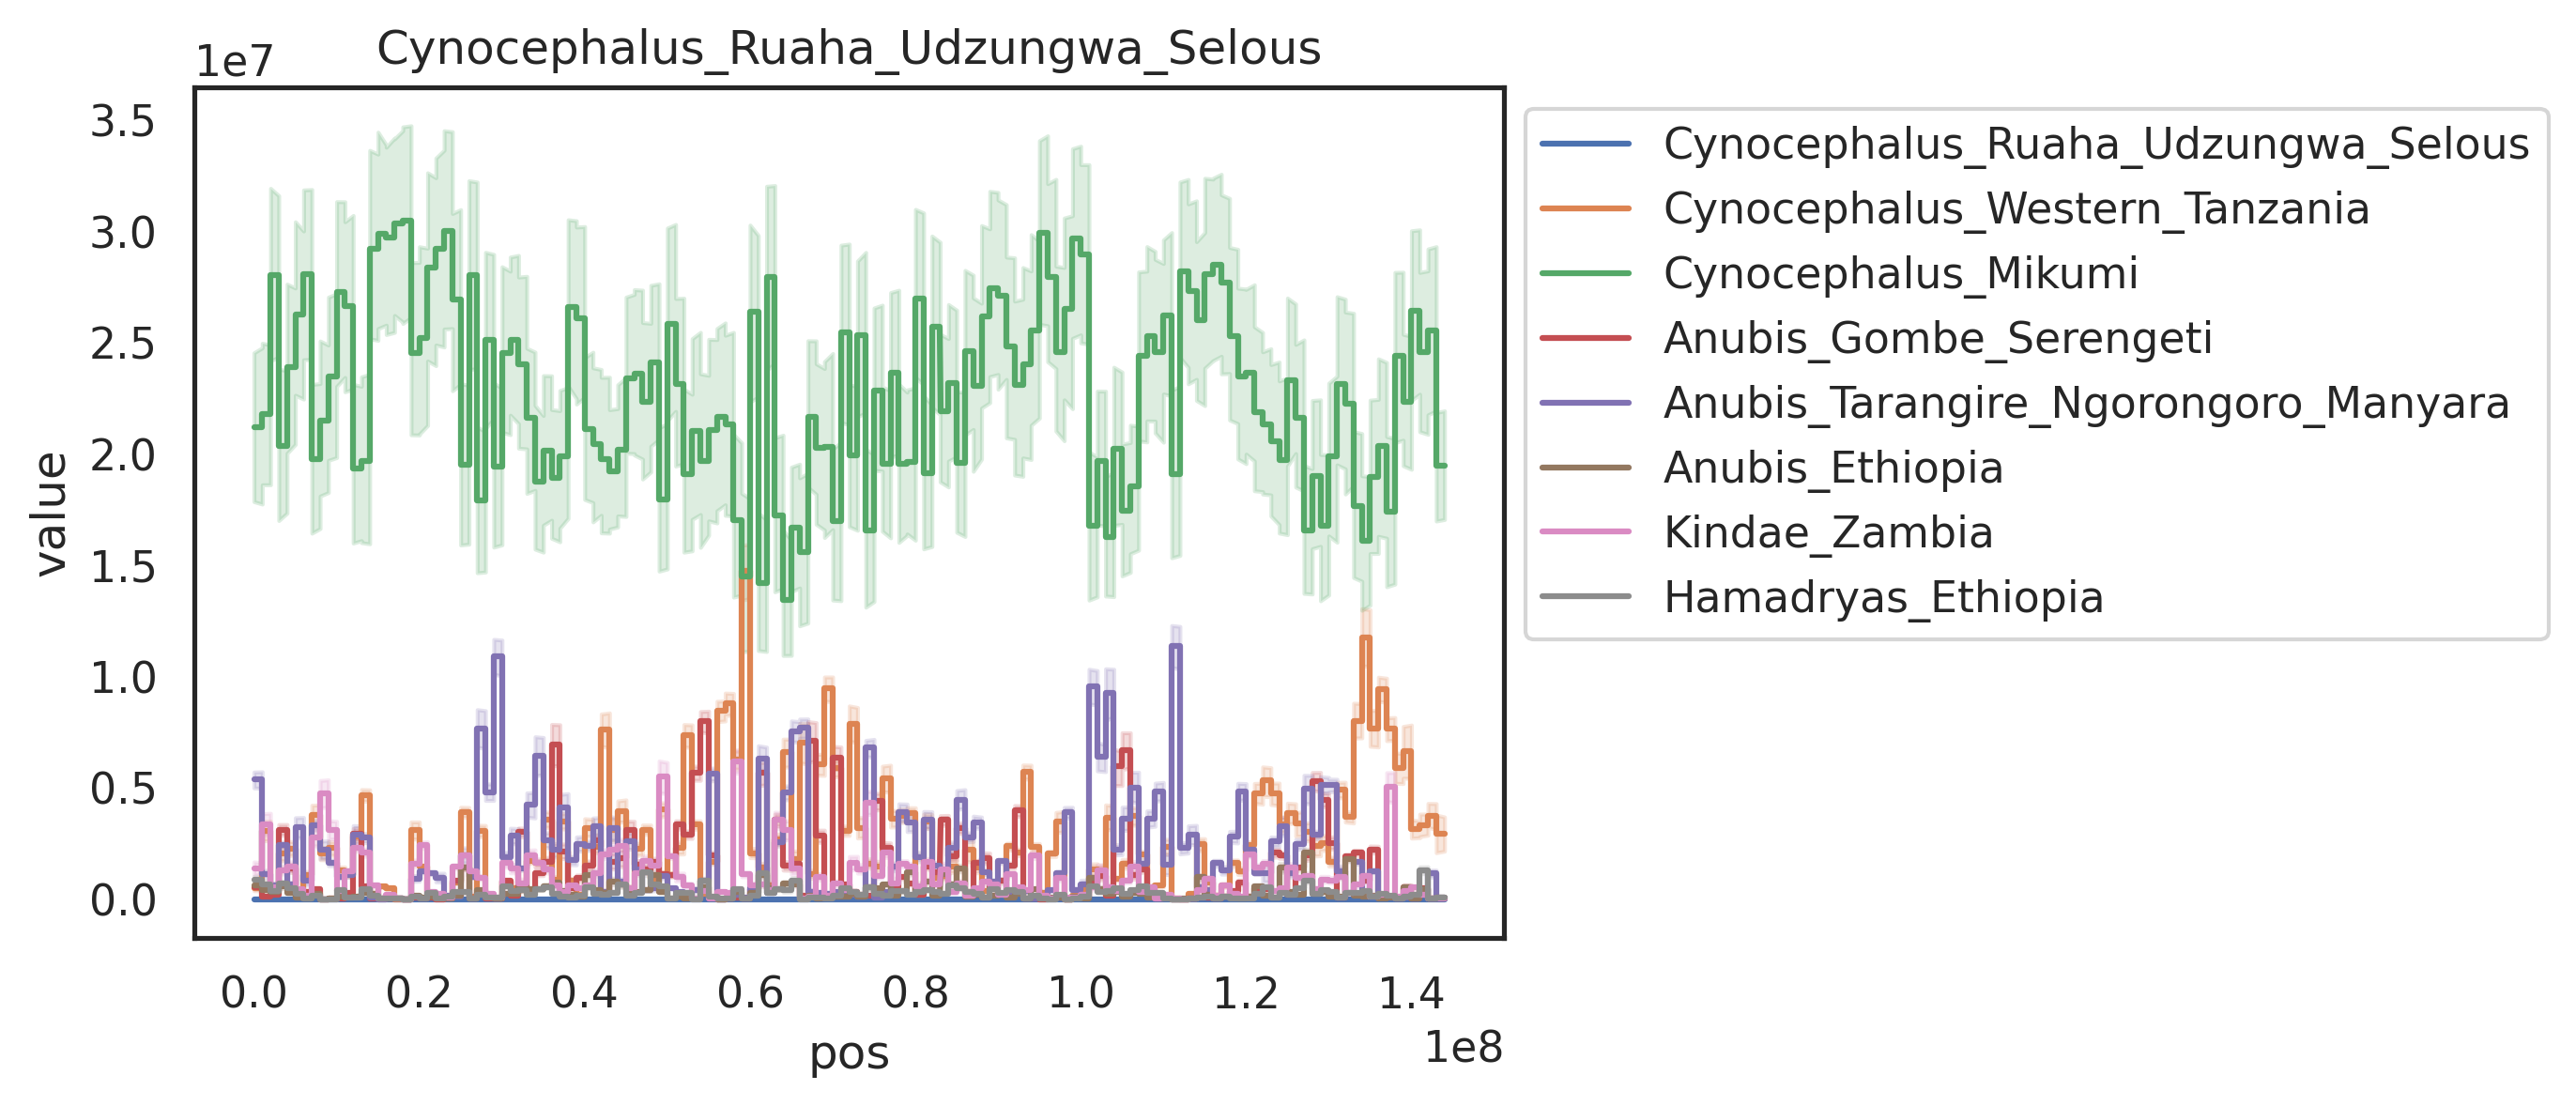

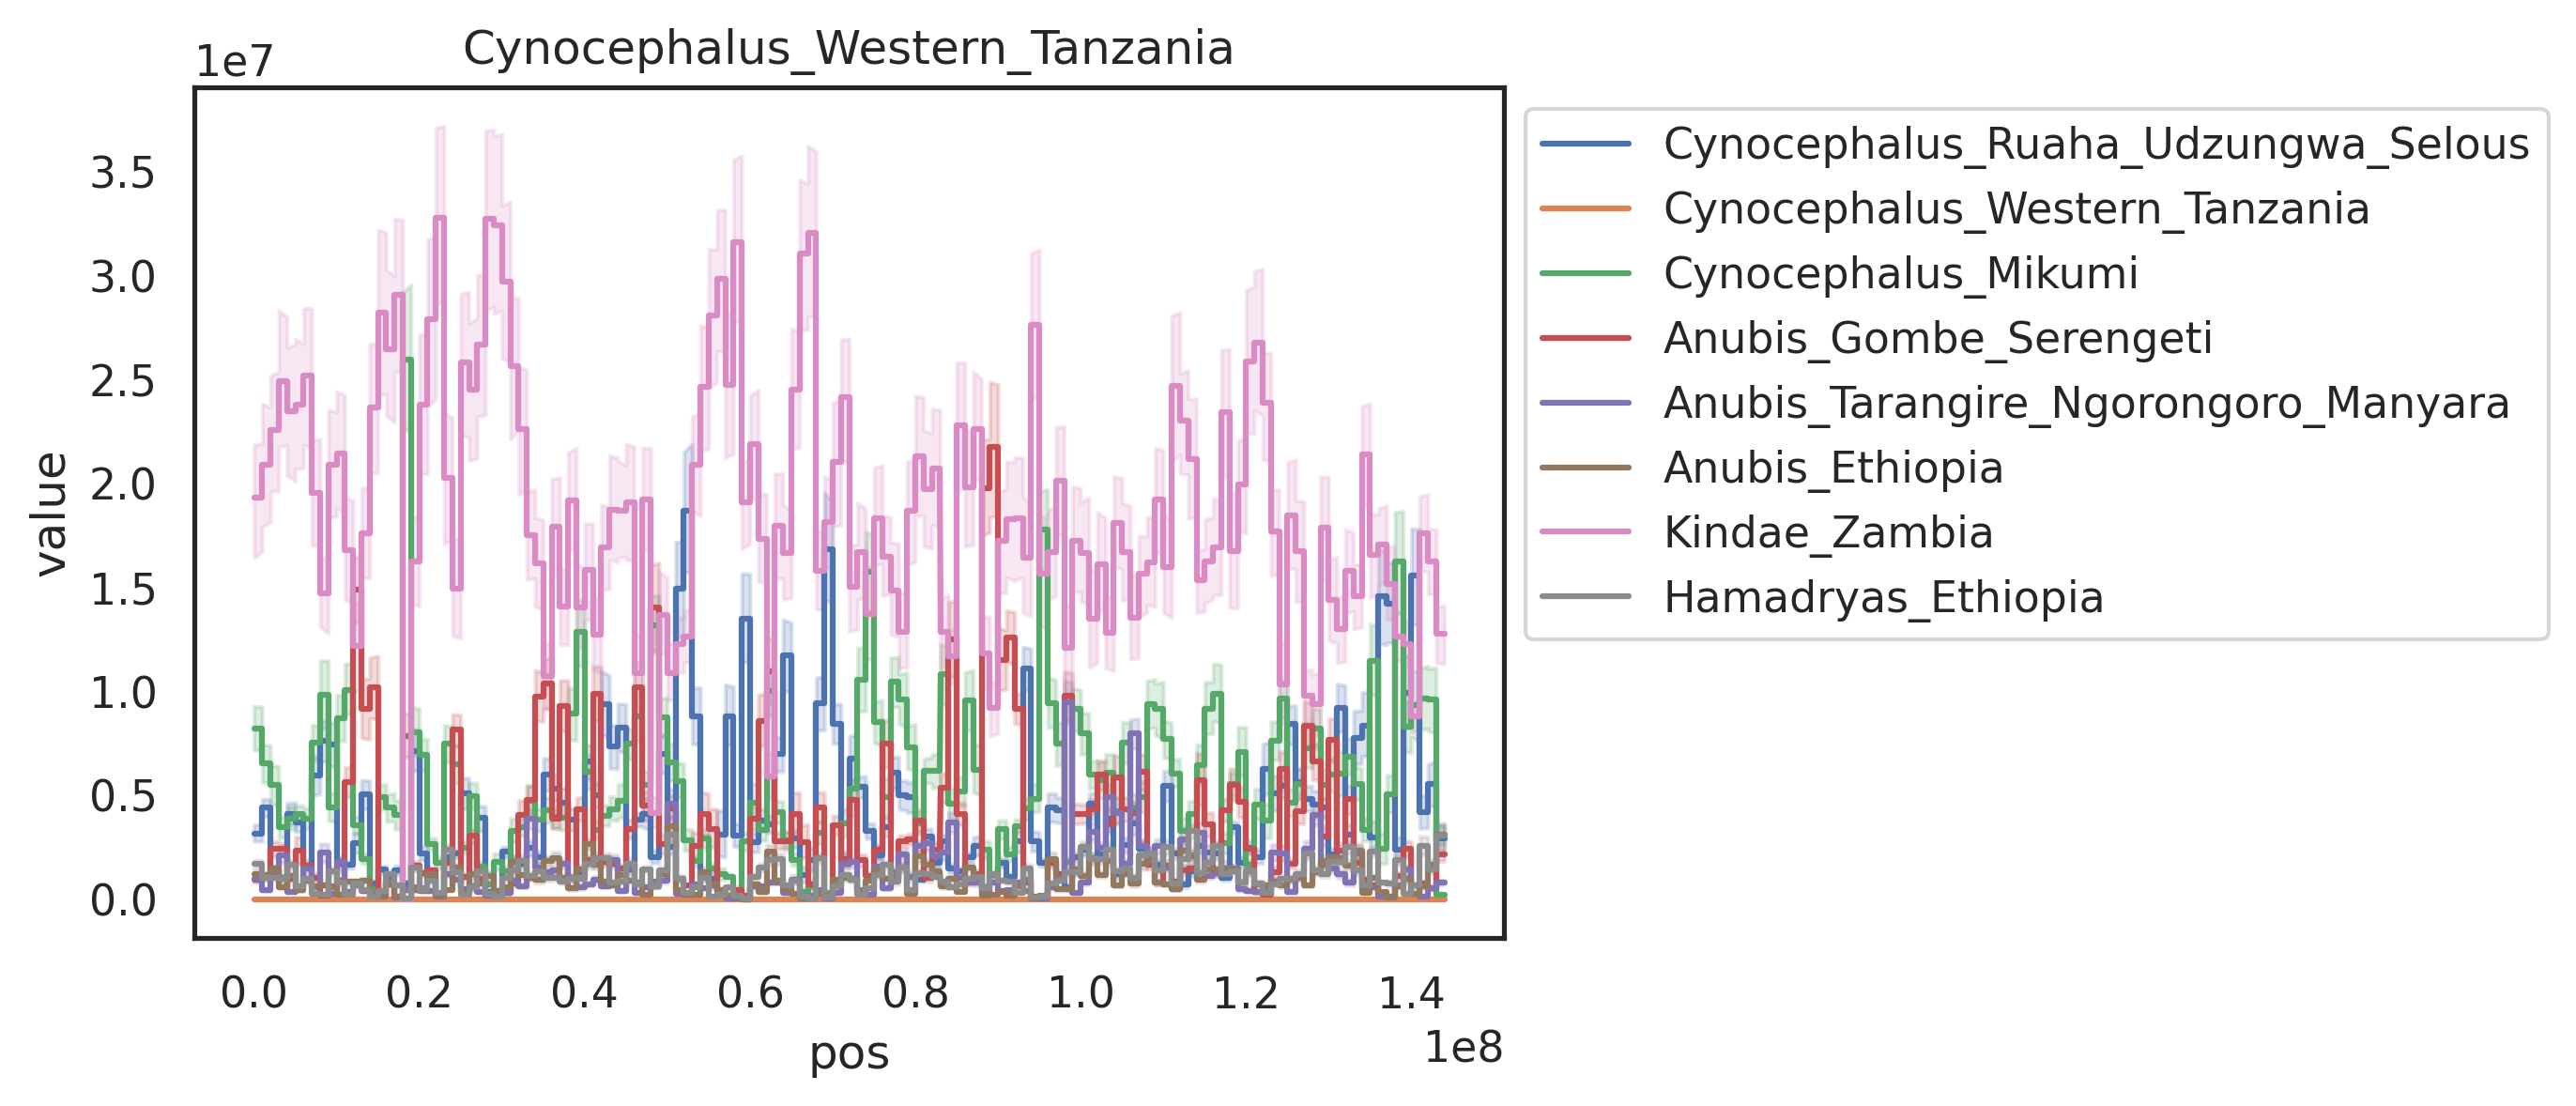

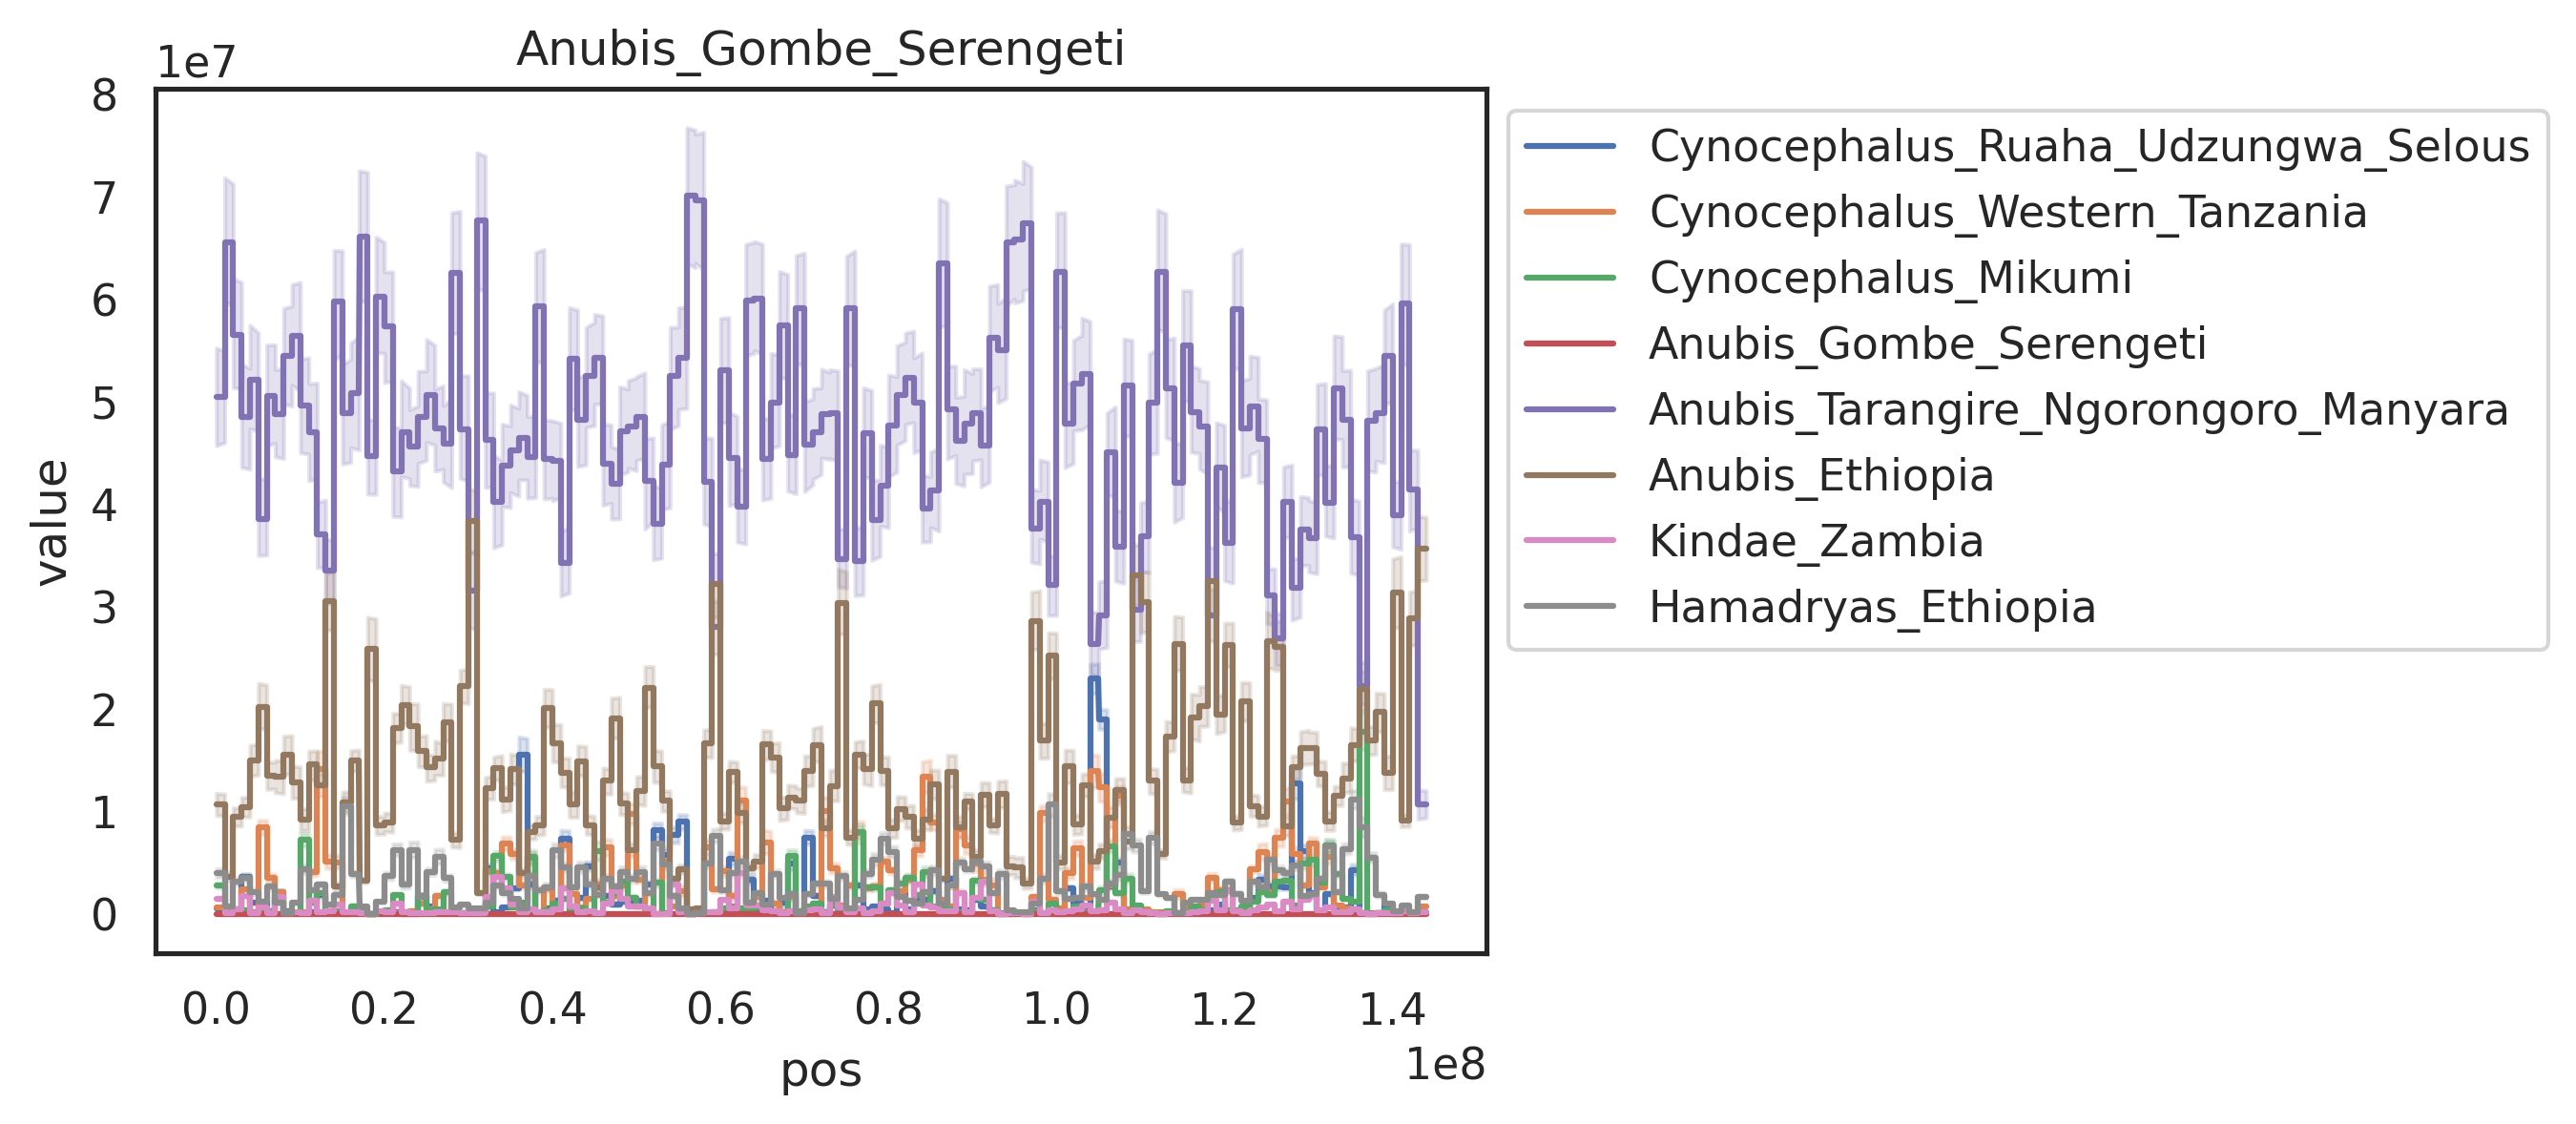

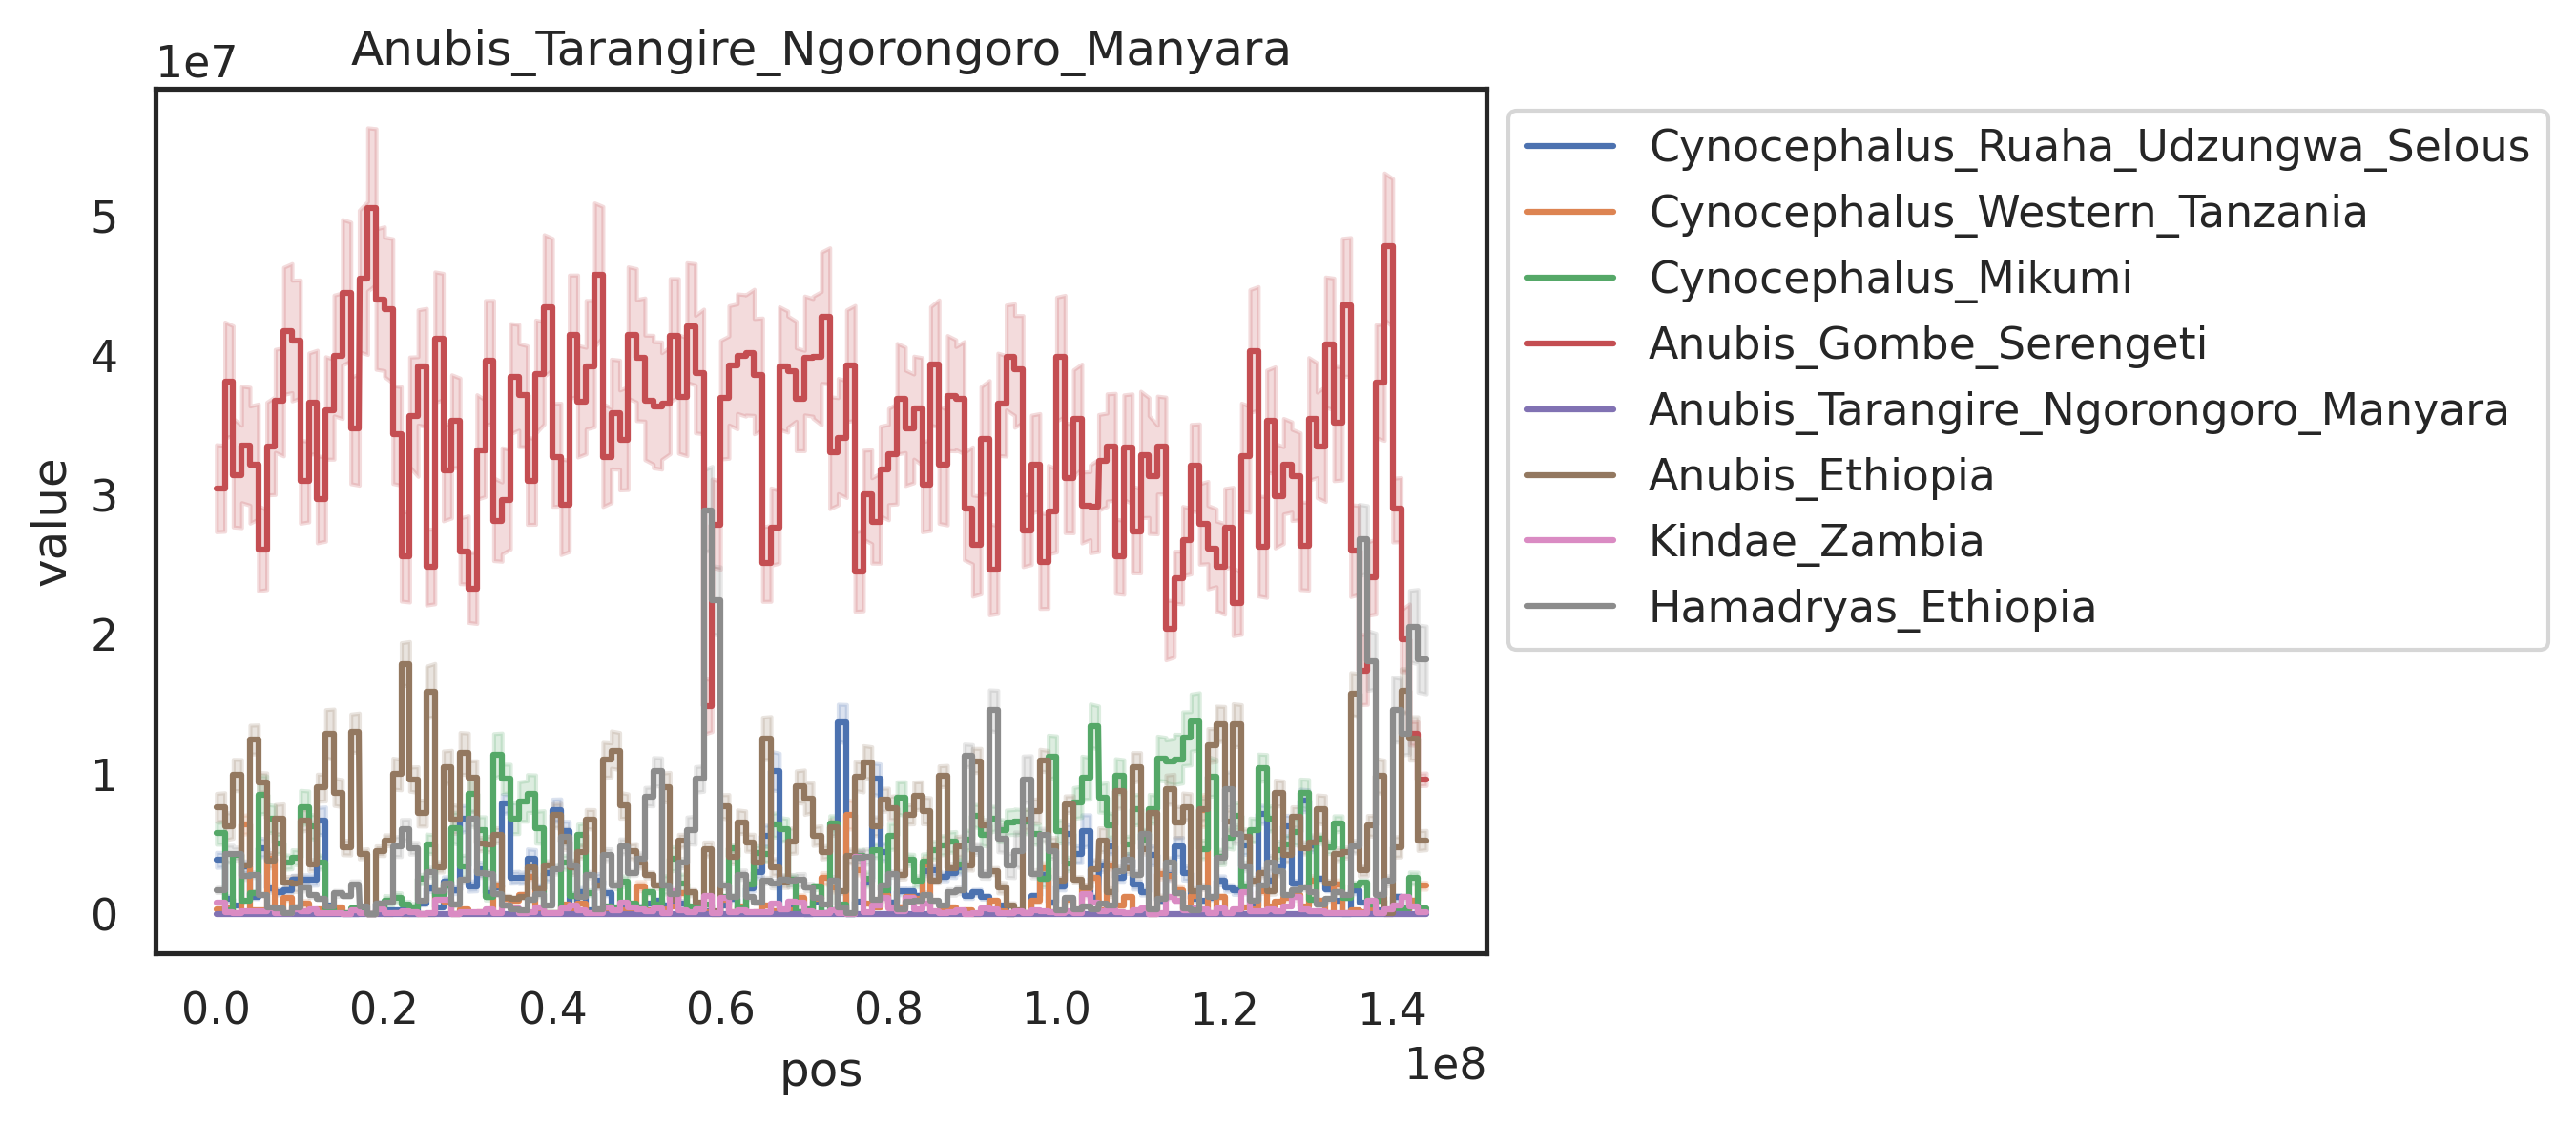

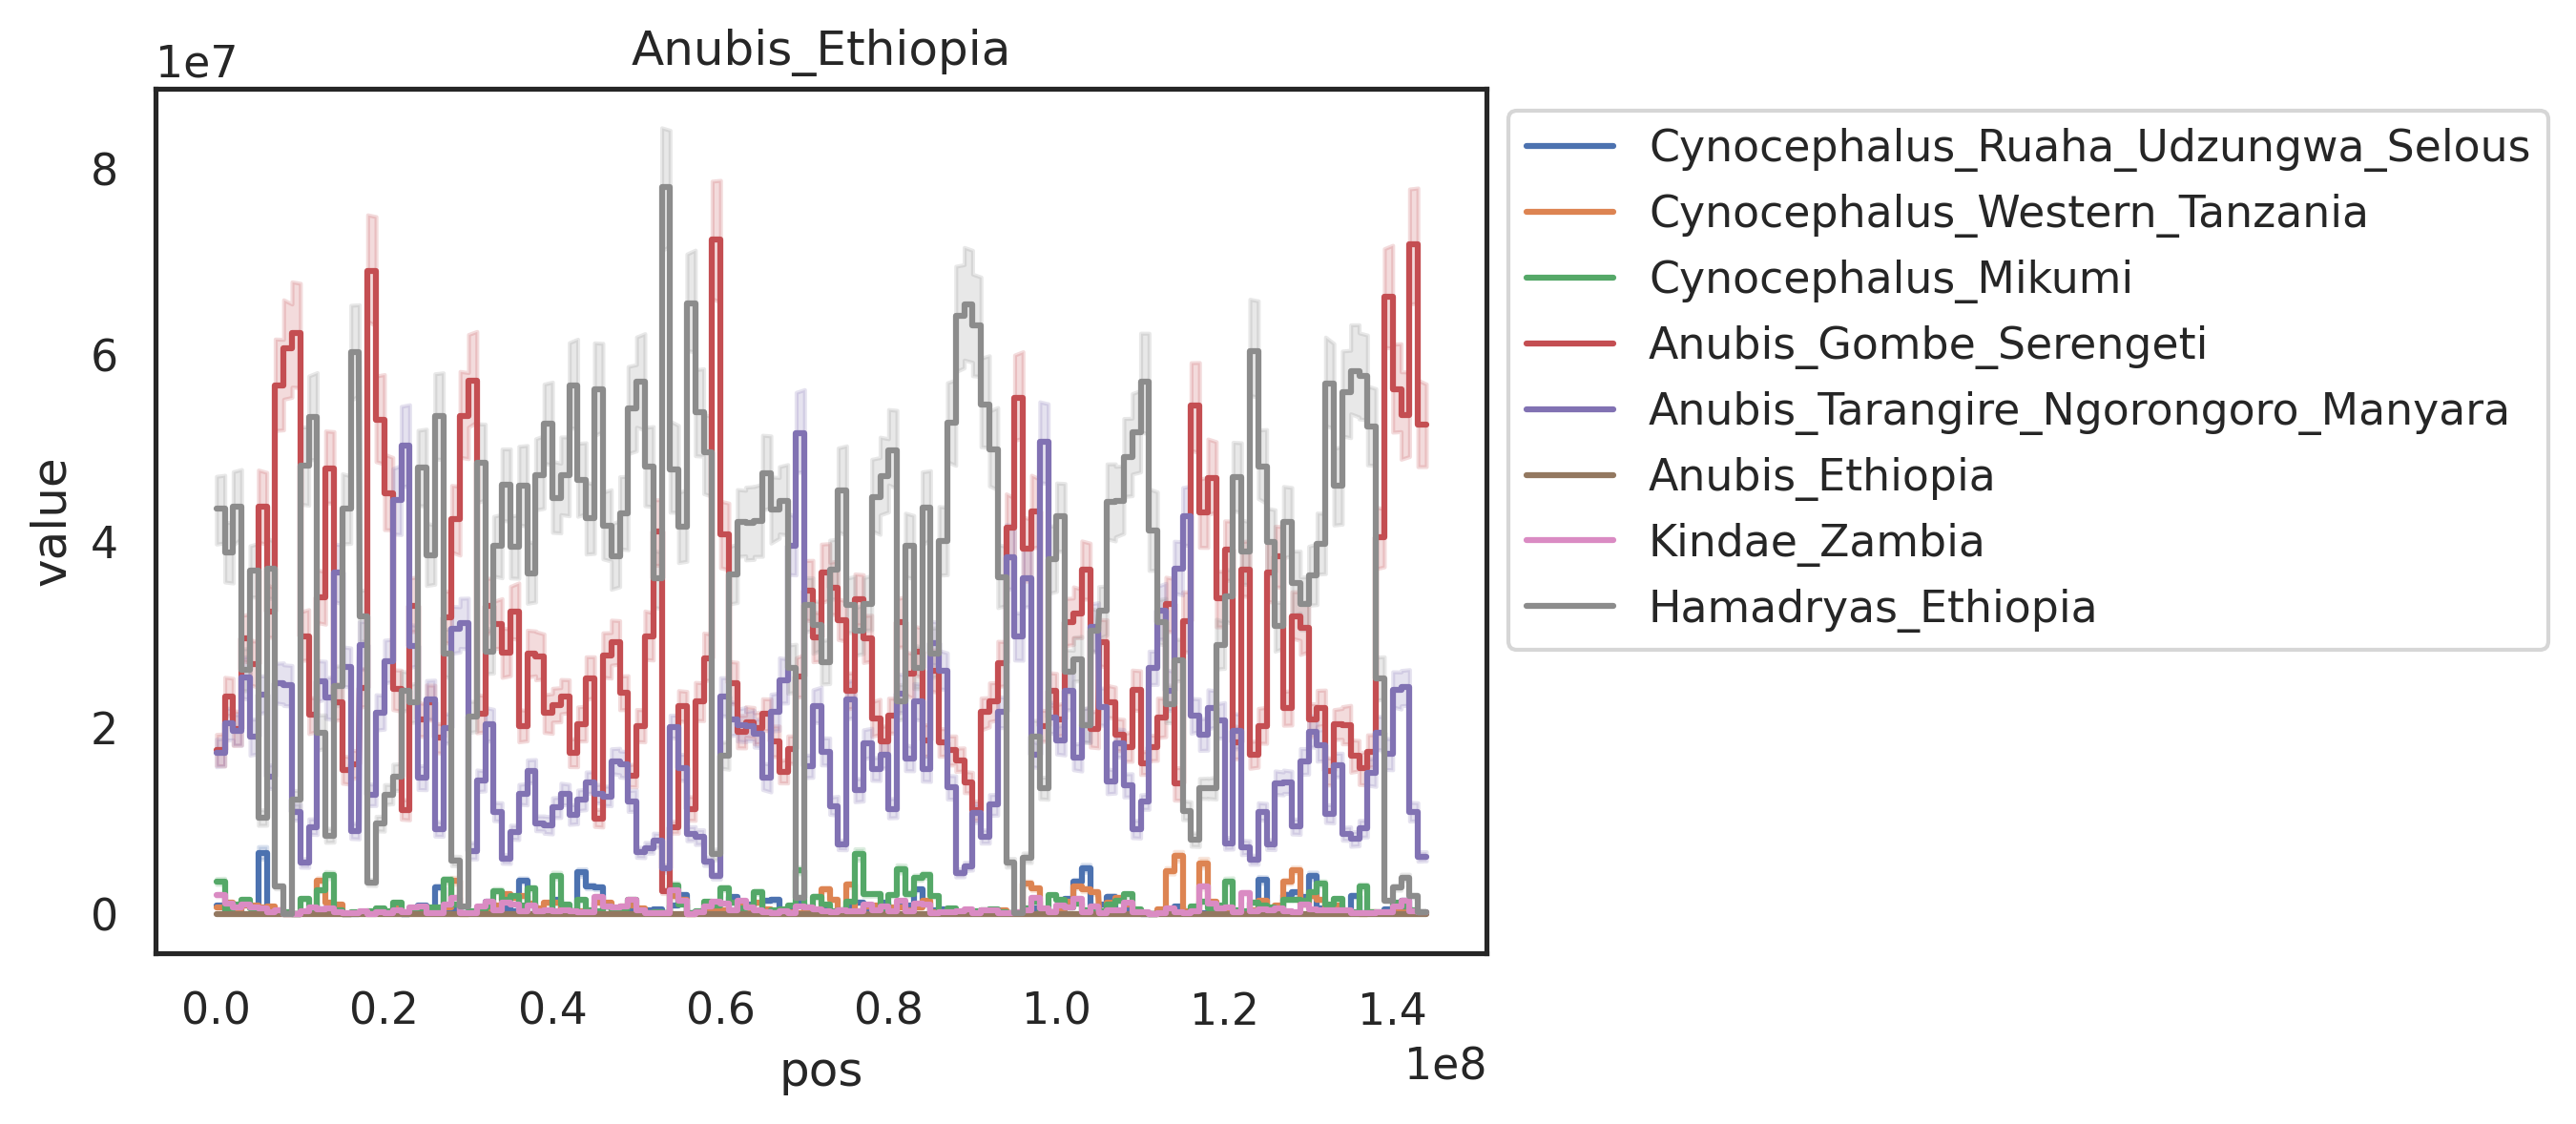

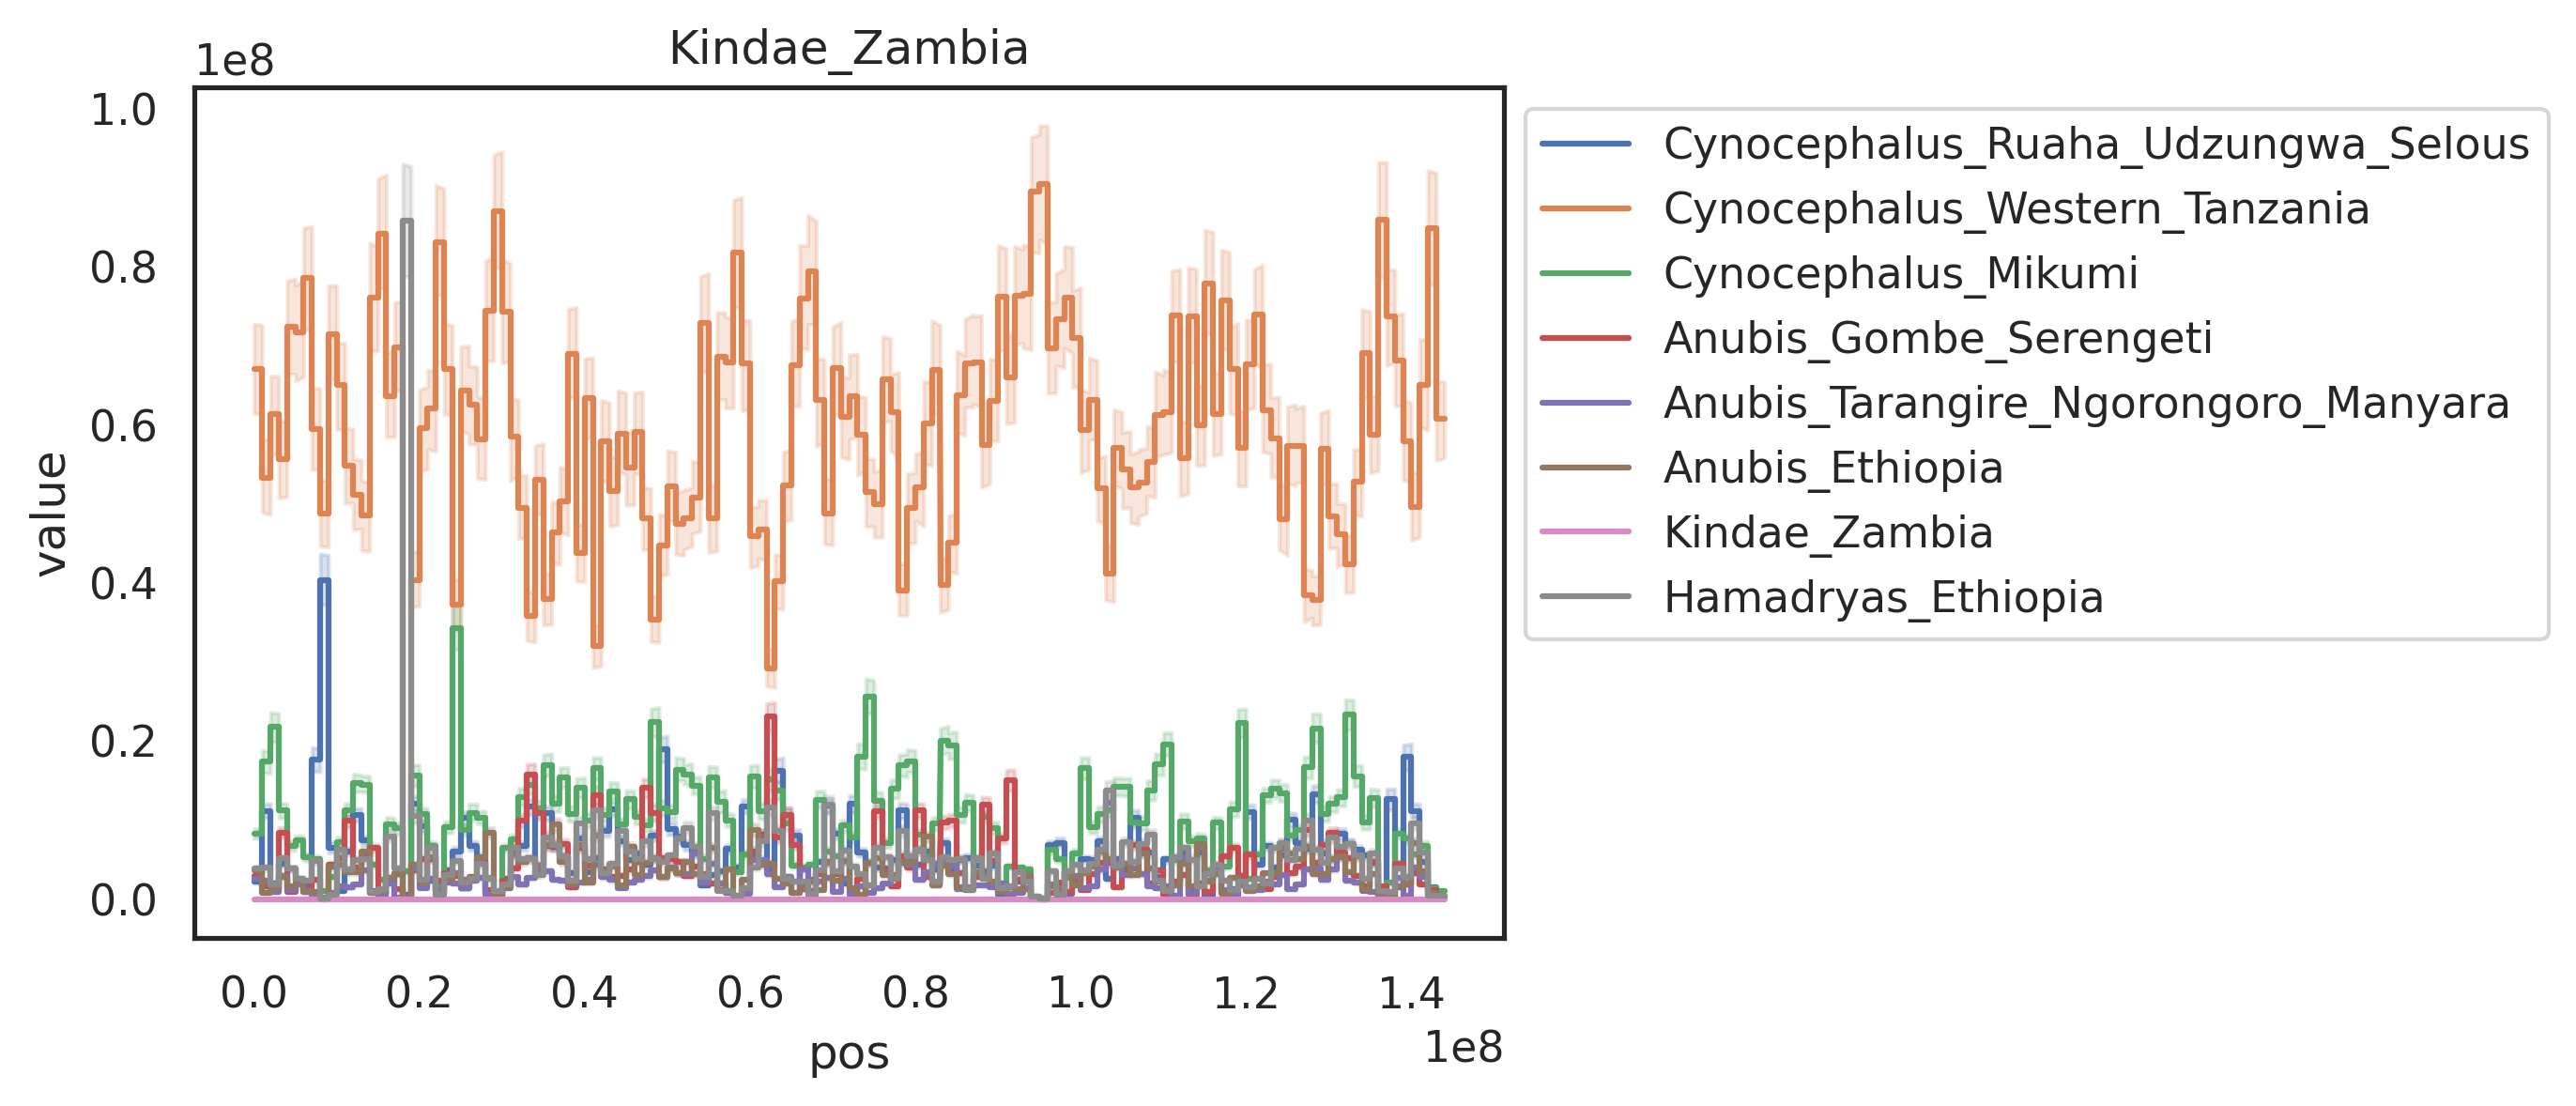

In [13]:
window = 1000000
for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
    if population == "Cynocephalus_Mikumi": #There is a problem with a painting in Mikumi
        continue
    all_df = create_paint_df_group(population, window)
    stair_df = stairs(all_df, endtrim=1)
    stair_df = stair_df.drop(columns=["paint", "individual", "start", "end"])
    stair_df = pd.melt(stair_df, id_vars="pos")
    plt.figure()
    g = sns.lineplot(data=stair_df, x="pos", y="value", hue="variable")
    g.legend(bbox_to_anchor=(1,1))
    g.set(title=population)
    plt.savefig("../results/group_painting_{}".format(population), transparent=True, bbox_inches="tight")

Checking paint regions in the Anubis Gombe case

In [8]:
window = 1000000
idfile.loc[idfile.inclusion==1]["pop"].unique()

all_df = create_paint_df_group("Anubis_Gombe_Serengeti", window)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [50]:
all_df

Cynocephalus_Ruaha_Udzungwa_Selous  Cynocephalus_Western_Tanzania  \
window                                                                      
0                                    10815                              0   
1                                        0                            332   
2                                     9079                           3119   
3                                   154502                          80003   
4                                        0                           2046   
...                                    ...                            ...   
139                                2692550                         355570   
140                                   6601                          18012   
141                                 714042                         262161   
142                                  29344                          27110   
143                                  71479                        1417668   

        Cynocephalus_Mikumi  Anubis_Gombe_Serengeti  \
window                                                
0                     27437                       0   
1                         0                       0   
2                     11710                       0   
3                      7610                       0   
4                         0                       0   
...                     ...                     ...   
139                  933039                       0   
140                   87298                       0   
141                  920810                       0   
142                   80159                       0   
143                  379537                       0   

        Anubis_Tarangire_Ngorongoro_Manyara  Anubis_Ethiopia  Kindae_Zambia  \
window                                                                        
0                                    904165             3341           1450   
1                                    999666                0              0   
2                                    716655           190378           7536   
3                                    572582           114791          49712   
4                                    813017           181713           3222   
...                                     ...              ...            ...   
139                               101387097         32225808         224780   
140                                77255977         62101742          69234   
141                               116561734         18860290         681584   
142                                88604597         50938355         101071   
143                                27776273         64124051         234977   

        Hamadryas_Ethiopia  paint  individual  
window                                         
0                    52575      0           0  
1                        0      0           0  
2                    61521      0           0  
3                    20798      0           0  
4                        0      0           0  
...                    ...    ...         ...  
139                2180896      9          13  
140                 460906      9          13  
141                1999159      9          13  
142                 219084      9          13  
143                3416278      9          13  

[20160 rows x 10 columns]

In [75]:
total_paint = all_df.iloc[-143:,:-4].sum(axis=1)
anubis_paint = all_df.iloc[-143:,:-4]["Anubis_Tarangire_Ngorongoro_Manyara"]+all_df.iloc[-143:,:-4]["Anubis_Ethiopia"]+all_df.iloc[-143:,:-4]["Anubis_Gombe_Serengeti"]
non_anubis_fraction = (total_paint-anubis_paint)/total_paint

<AxesSubplot:ylabel='Count'>

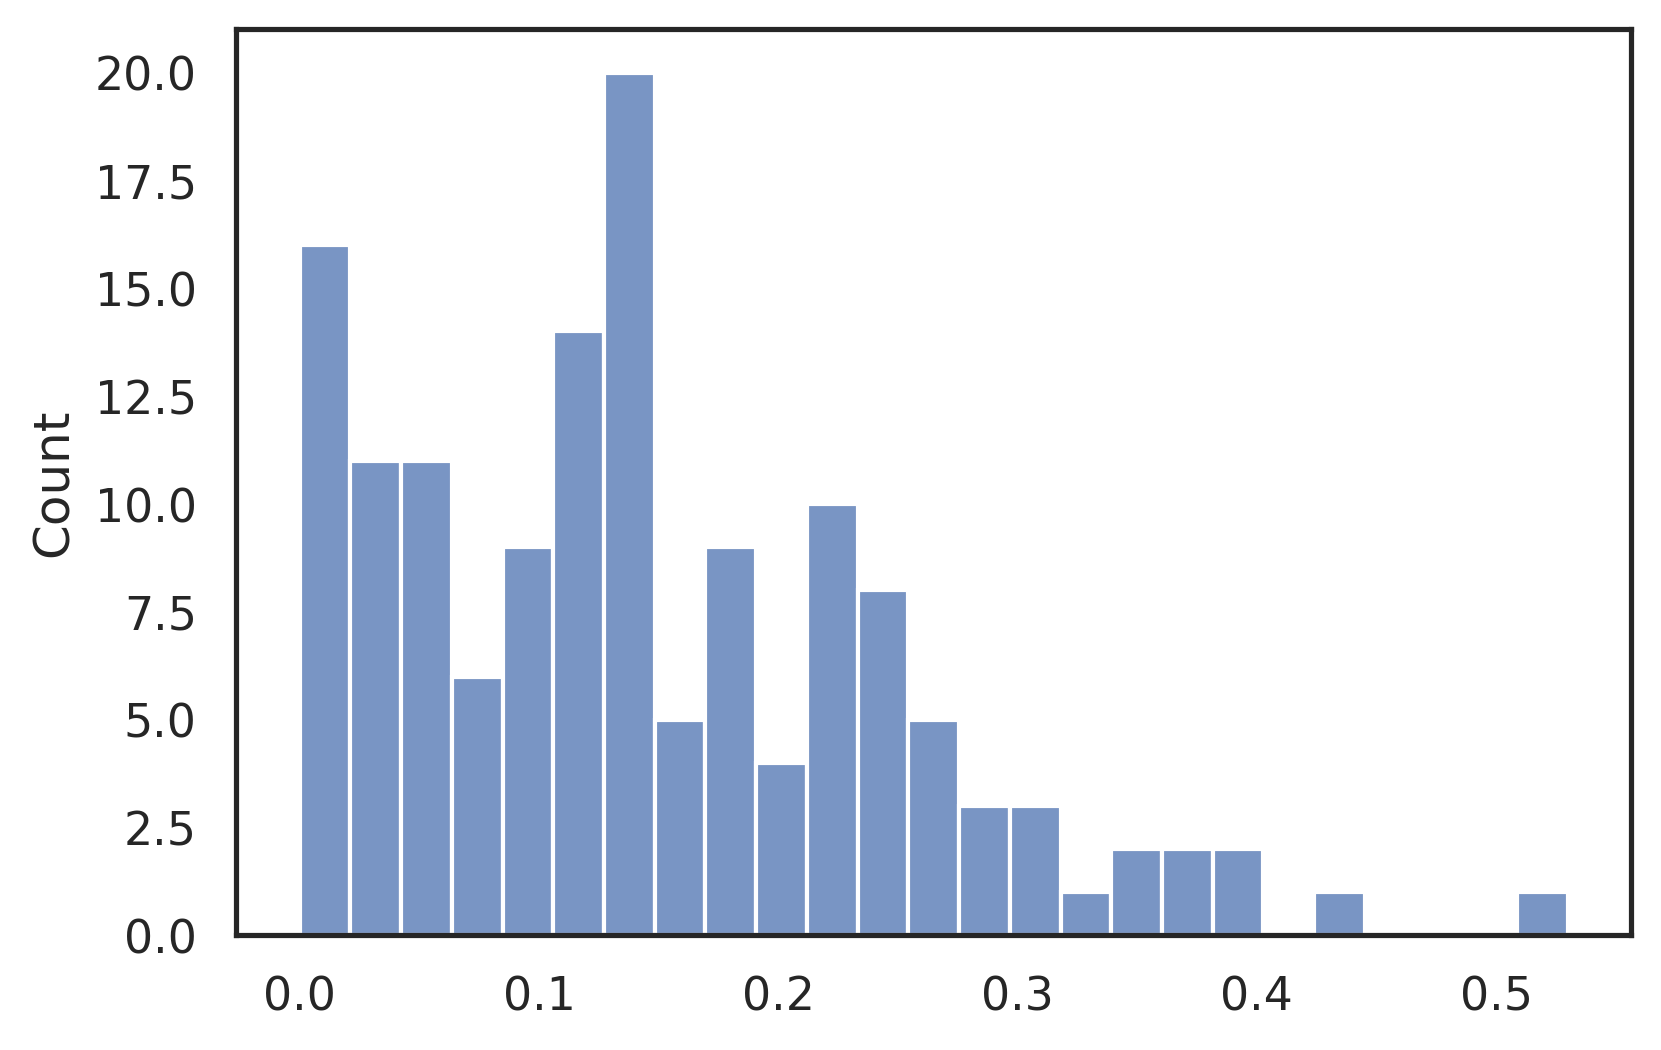

In [80]:
sns.histplot(non_anubis_fraction, bins=25)

In [18]:
all_df.iloc[:,:-2]

Cynocephalus_Ruaha_Udzungwa_Selous  Cynocephalus_Western_Tanzania  \
window                                                                      
0                                    10815                              0   
1                                        0                            332   
2                                     9079                           3119   
3                                   154502                          80003   
4                                        0                           2046   
...                                    ...                            ...   
139                                2692550                         355570   
140                                   6601                          18012   
141                                 714042                         262161   
142                                  29344                          27110   
143                                  71479                        1417668   

        Cynocephalus_Mikumi  Anubis_Gombe_Serengeti  \
window                                                
0                     27437                       0   
1                         0                       0   
2                     11710                       0   
3                      7610                       0   
4                         0                       0   
...                     ...                     ...   
139                  933039                       0   
140                   87298                       0   
141                  920810                       0   
142                   80159                       0   
143                  379537                       0   

        Anubis_Tarangire_Ngorongoro_Manyara  Anubis_Ethiopia  Kindae_Zambia  \
window                                                                        
0                                    904165             3341           1450   
1                                    999666                0              0   
2                                    716655           190378           7536   
3                                    572582           114791          49712   
4                                    813017           181713           3222   
...                                     ...              ...            ...   
139                               101387097         32225808         224780   
140                                77255977         62101742          69234   
141                               116561734         18860290         681584   
142                                88604597         50938355         101071   
143                                27776273         64124051         234977   

        Hamadryas_Ethiopia  
window                      
0                    52575  
1                        0  
2                    61521  
3                    20798  
4                        0  
...                    ...  
139                2180896  
140                 460906  
141                1999159  
142                 219084  
143                3416278  

[20160 rows x 8 columns]

Same, but allowing to copy from the same population

0
1
2
3
10
11
4
5
6
7
8
9
15
39
40
43
44
48
49
50
51
52
54
55
56
58
59
41
42
45
46
47
53
57
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


FileNotFoundError: [Errno 2] No such file or directory: '/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/chromopaintings/copy98.samples.out'

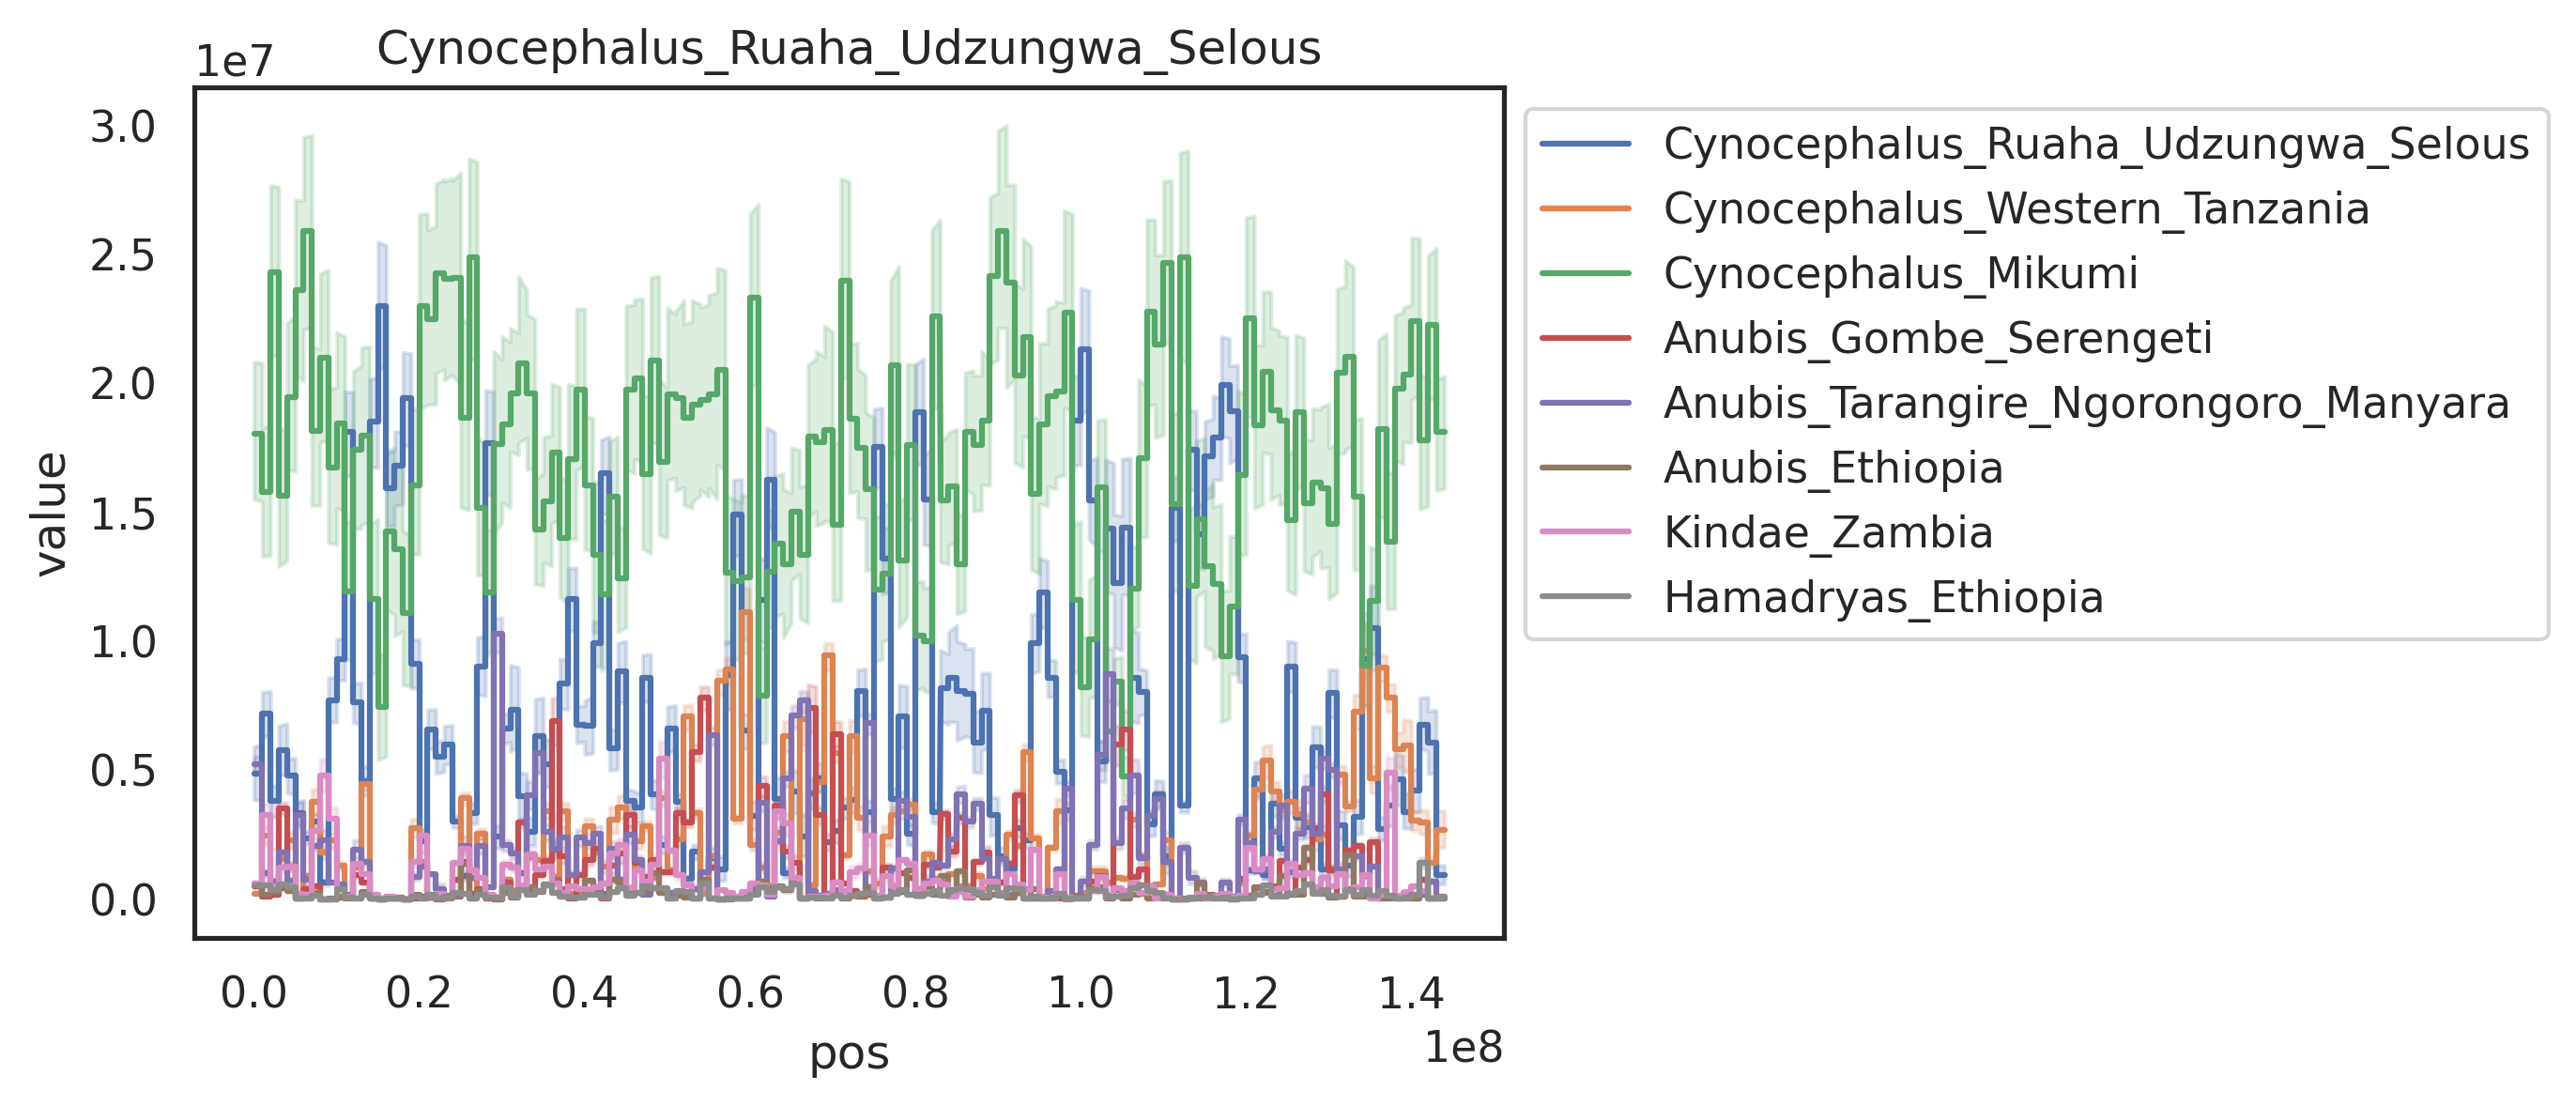

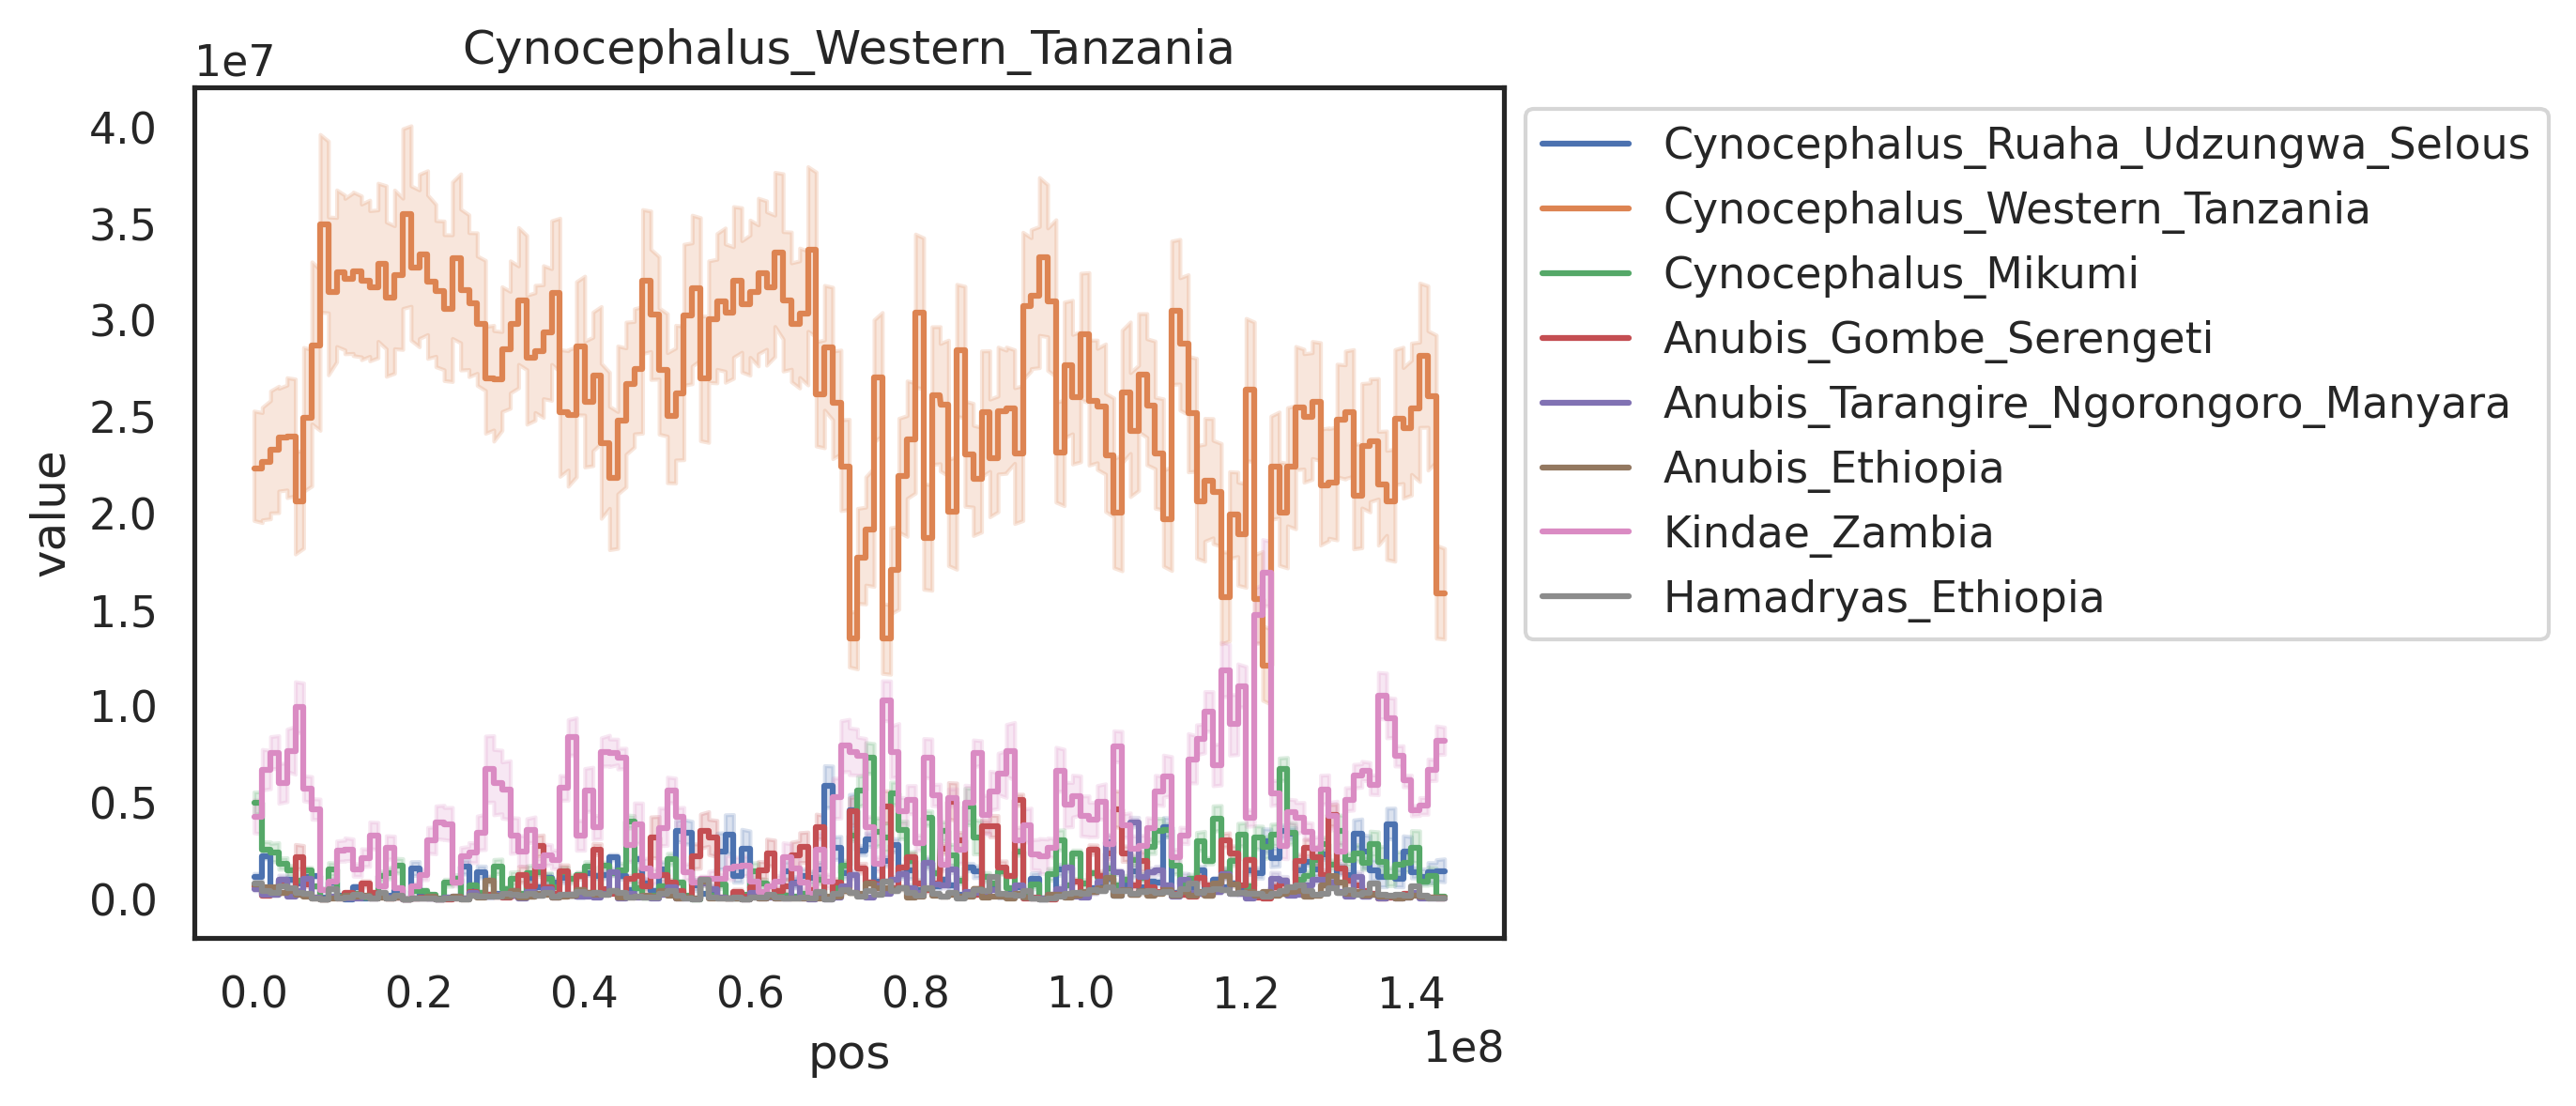

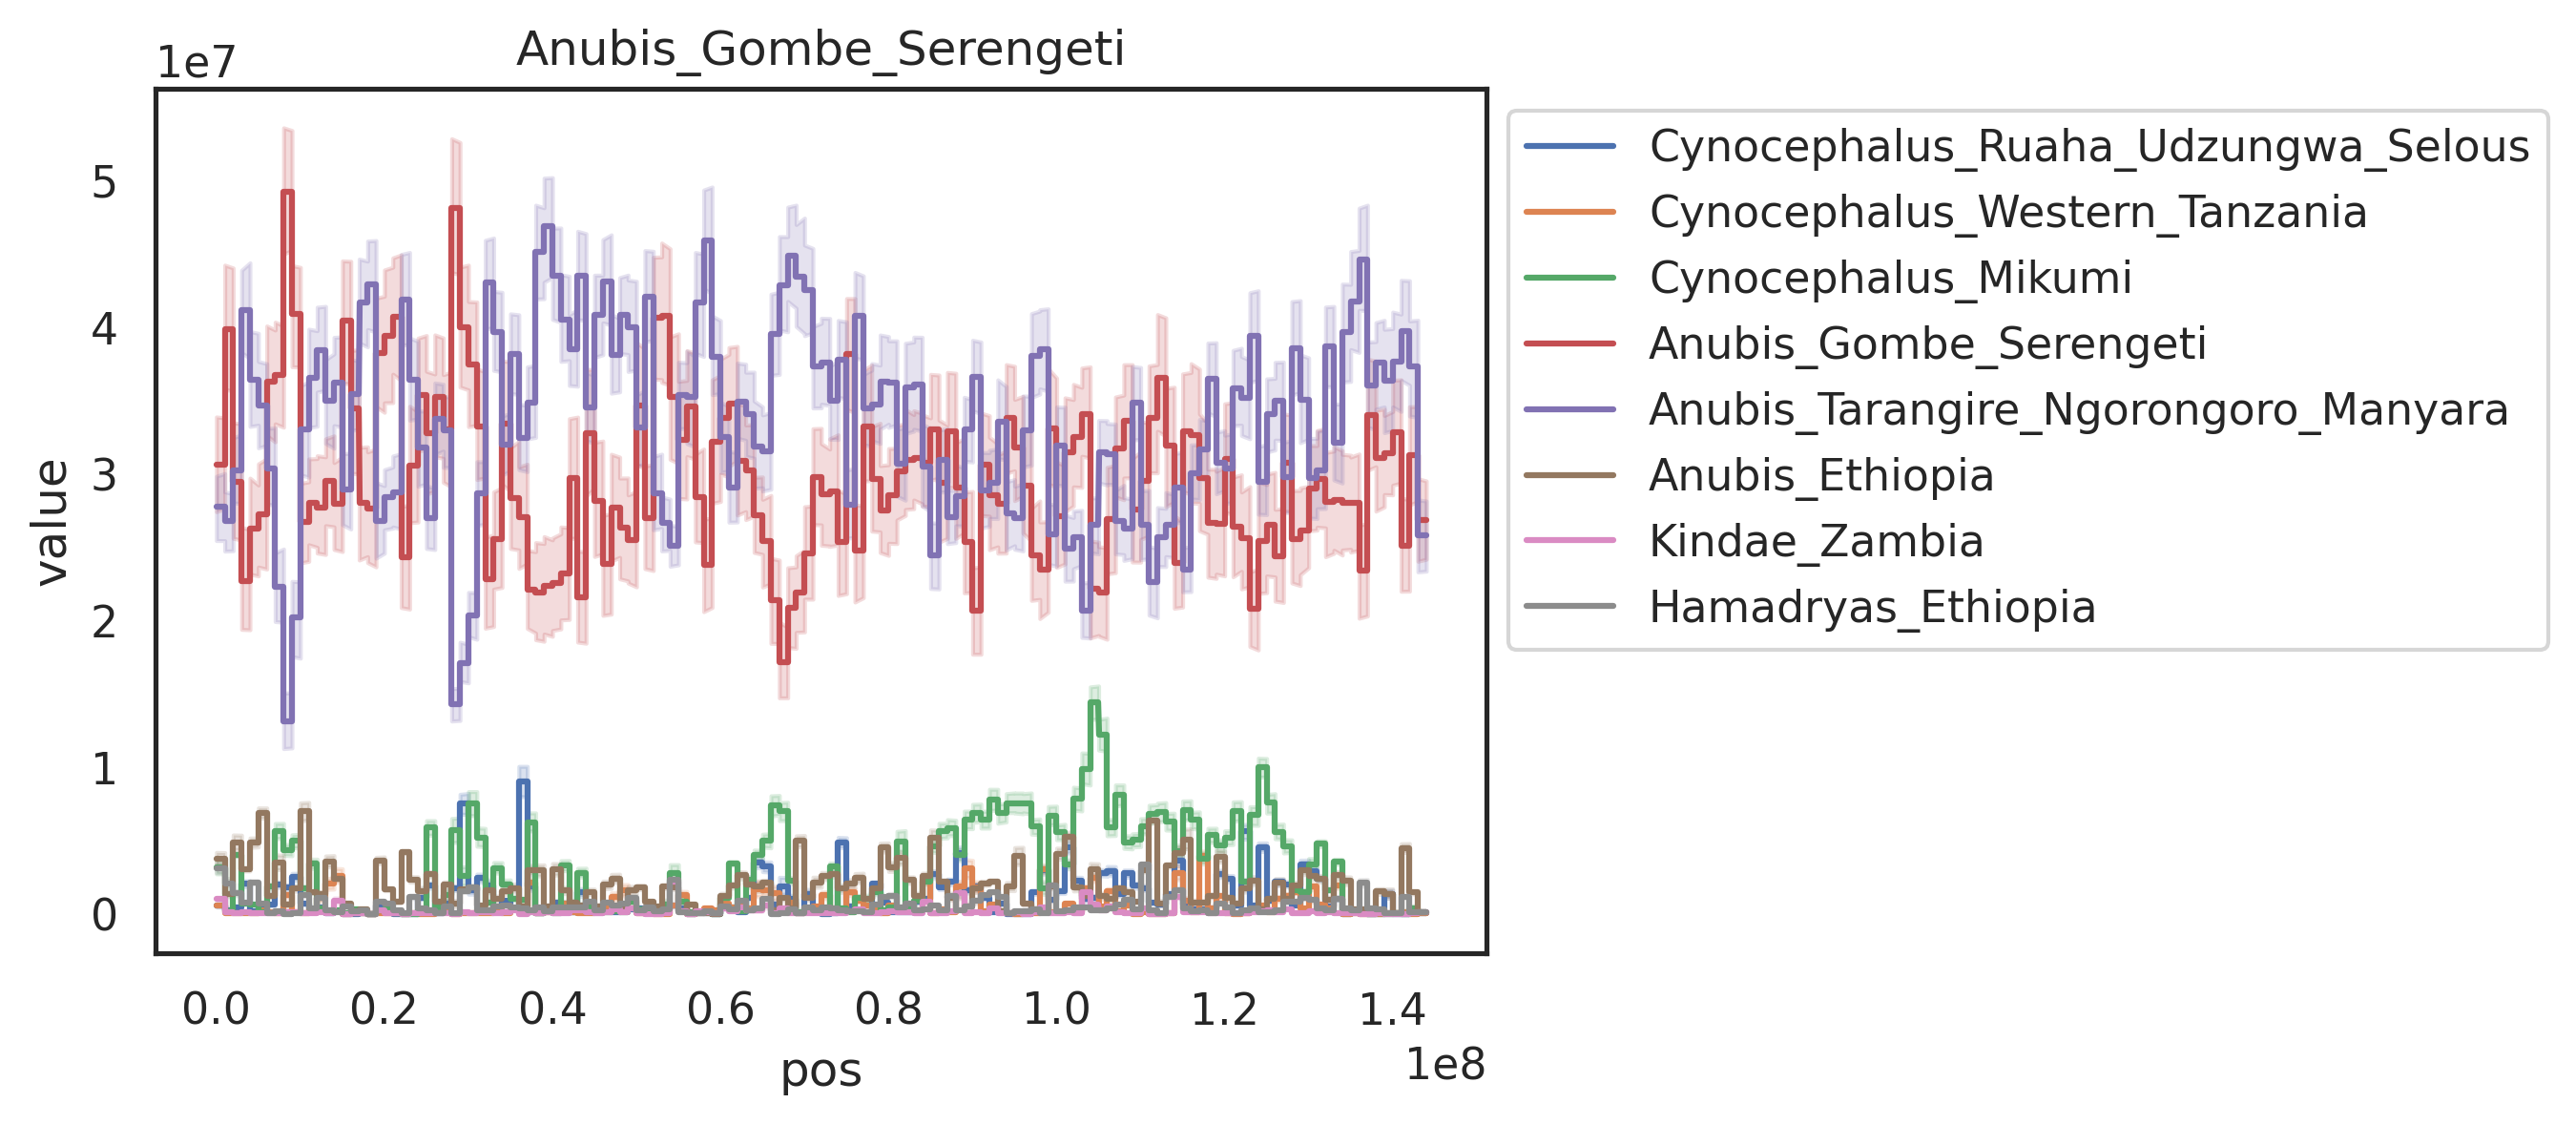

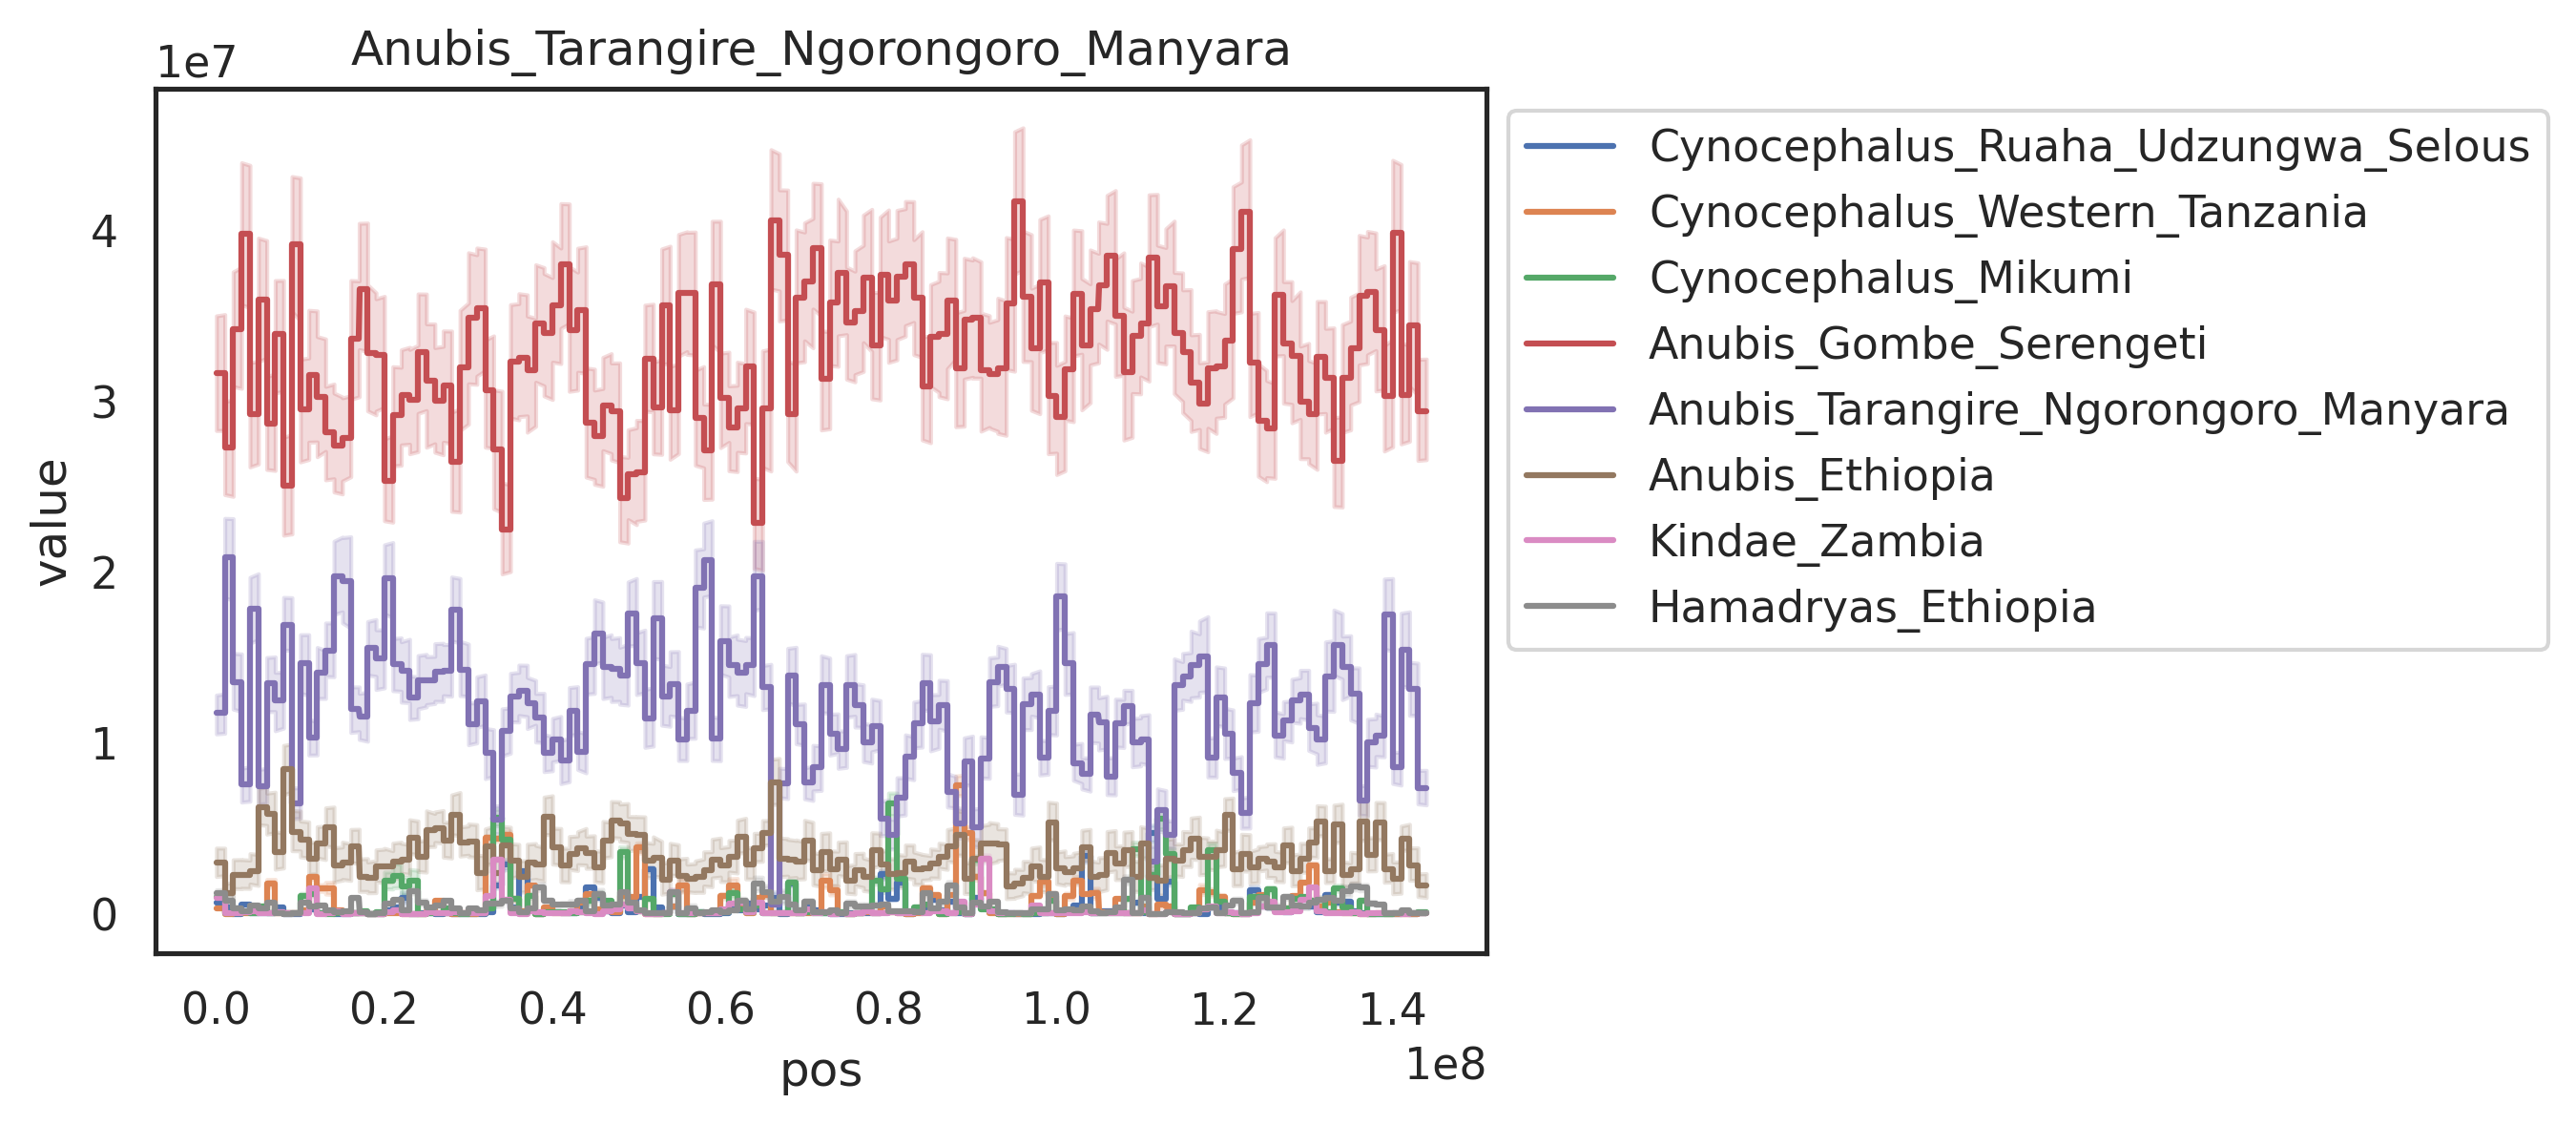

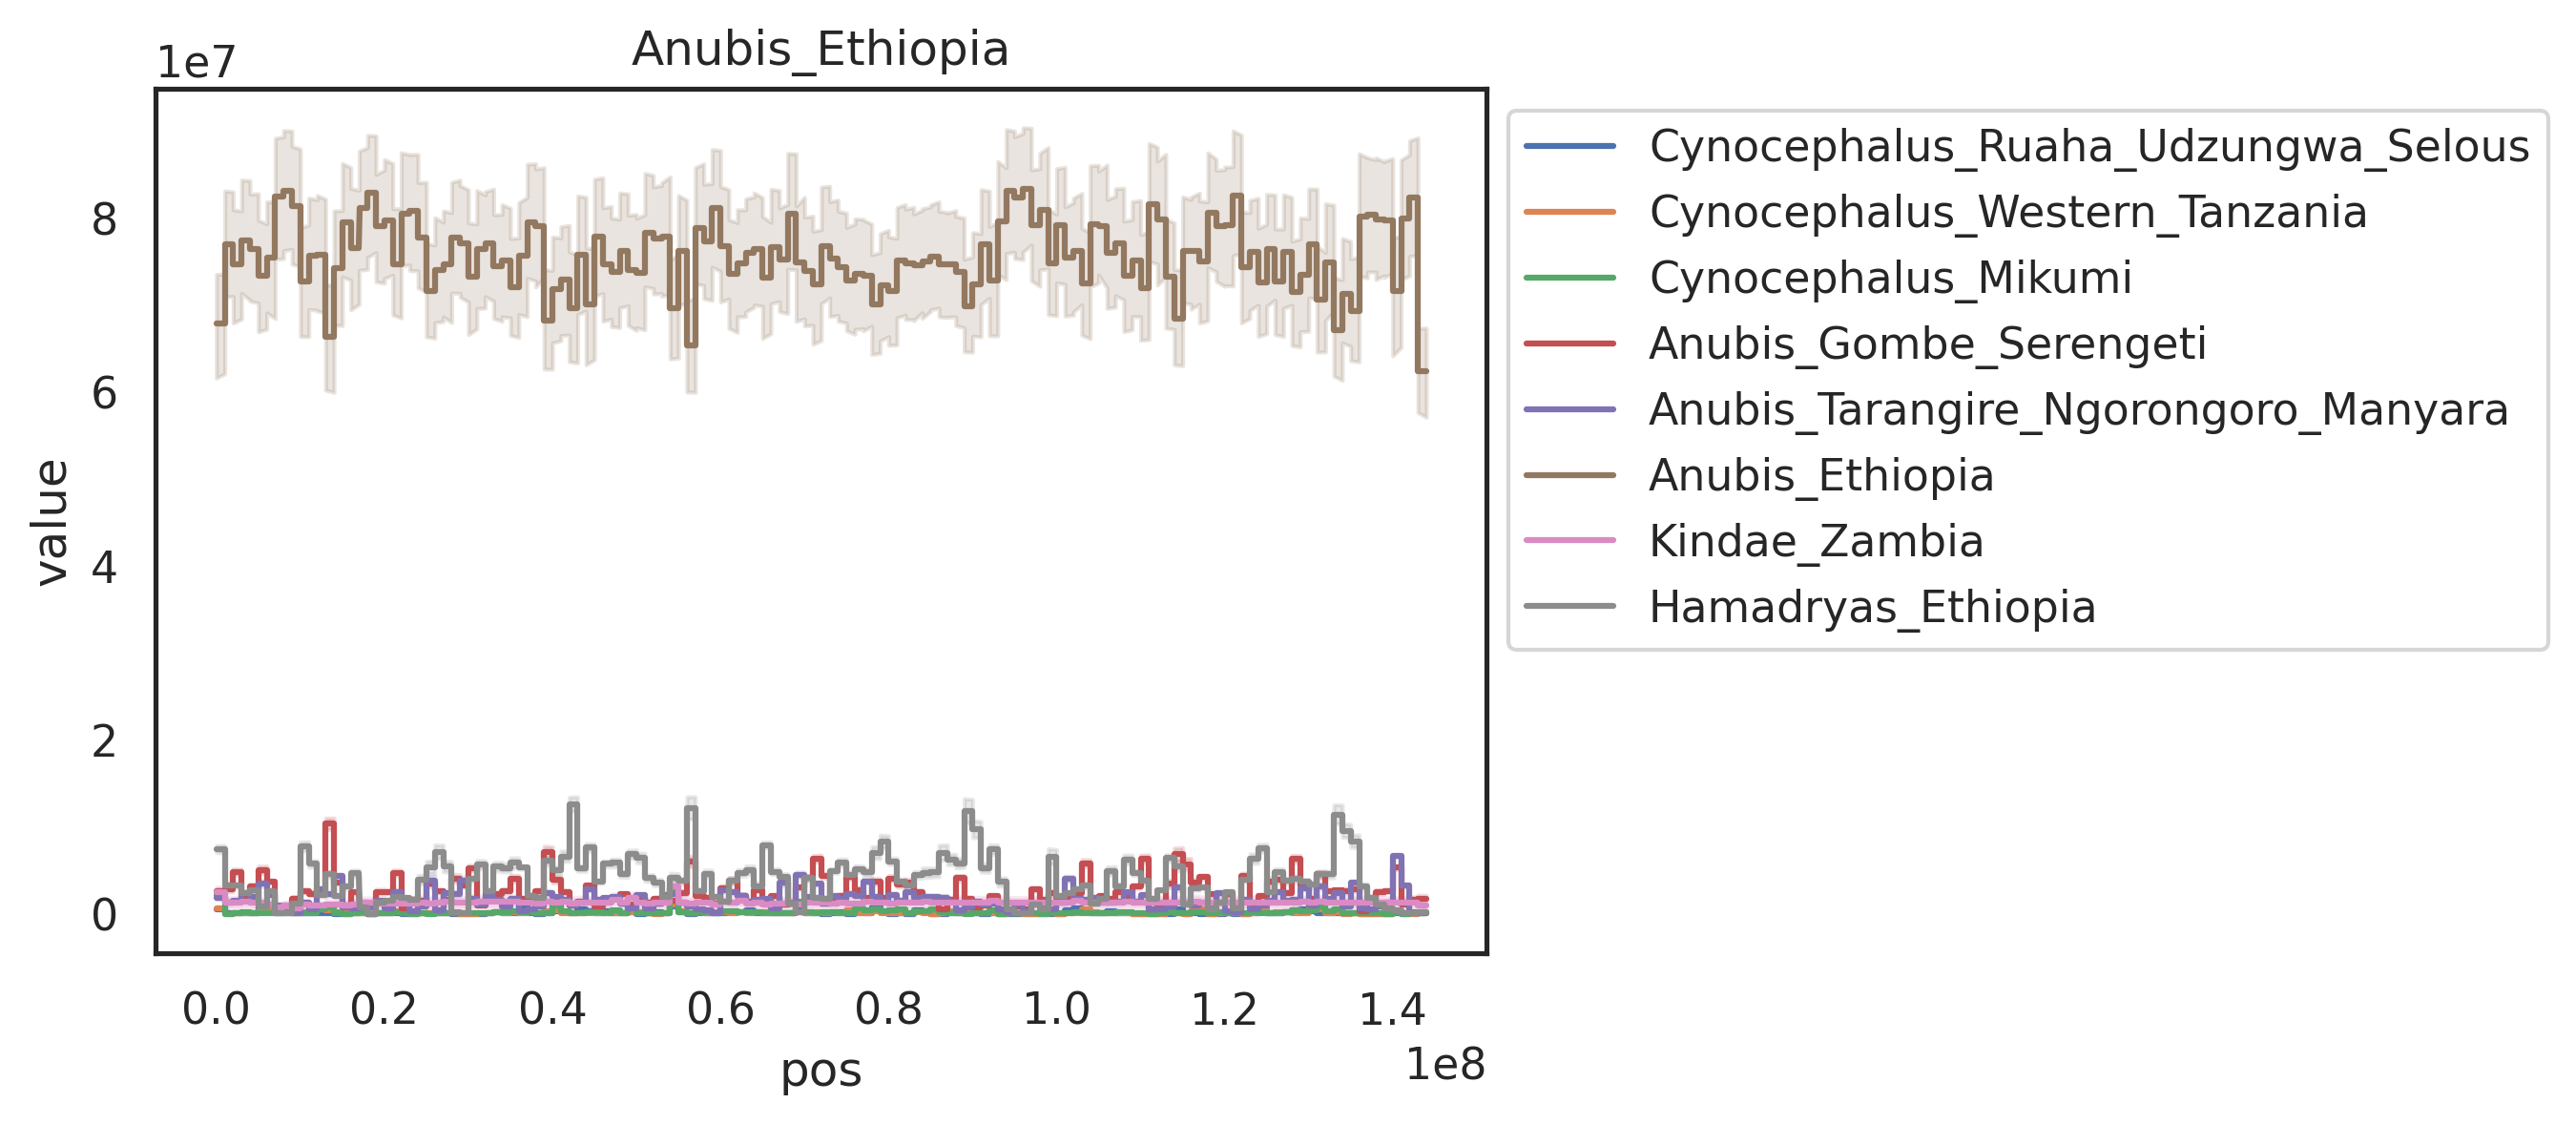

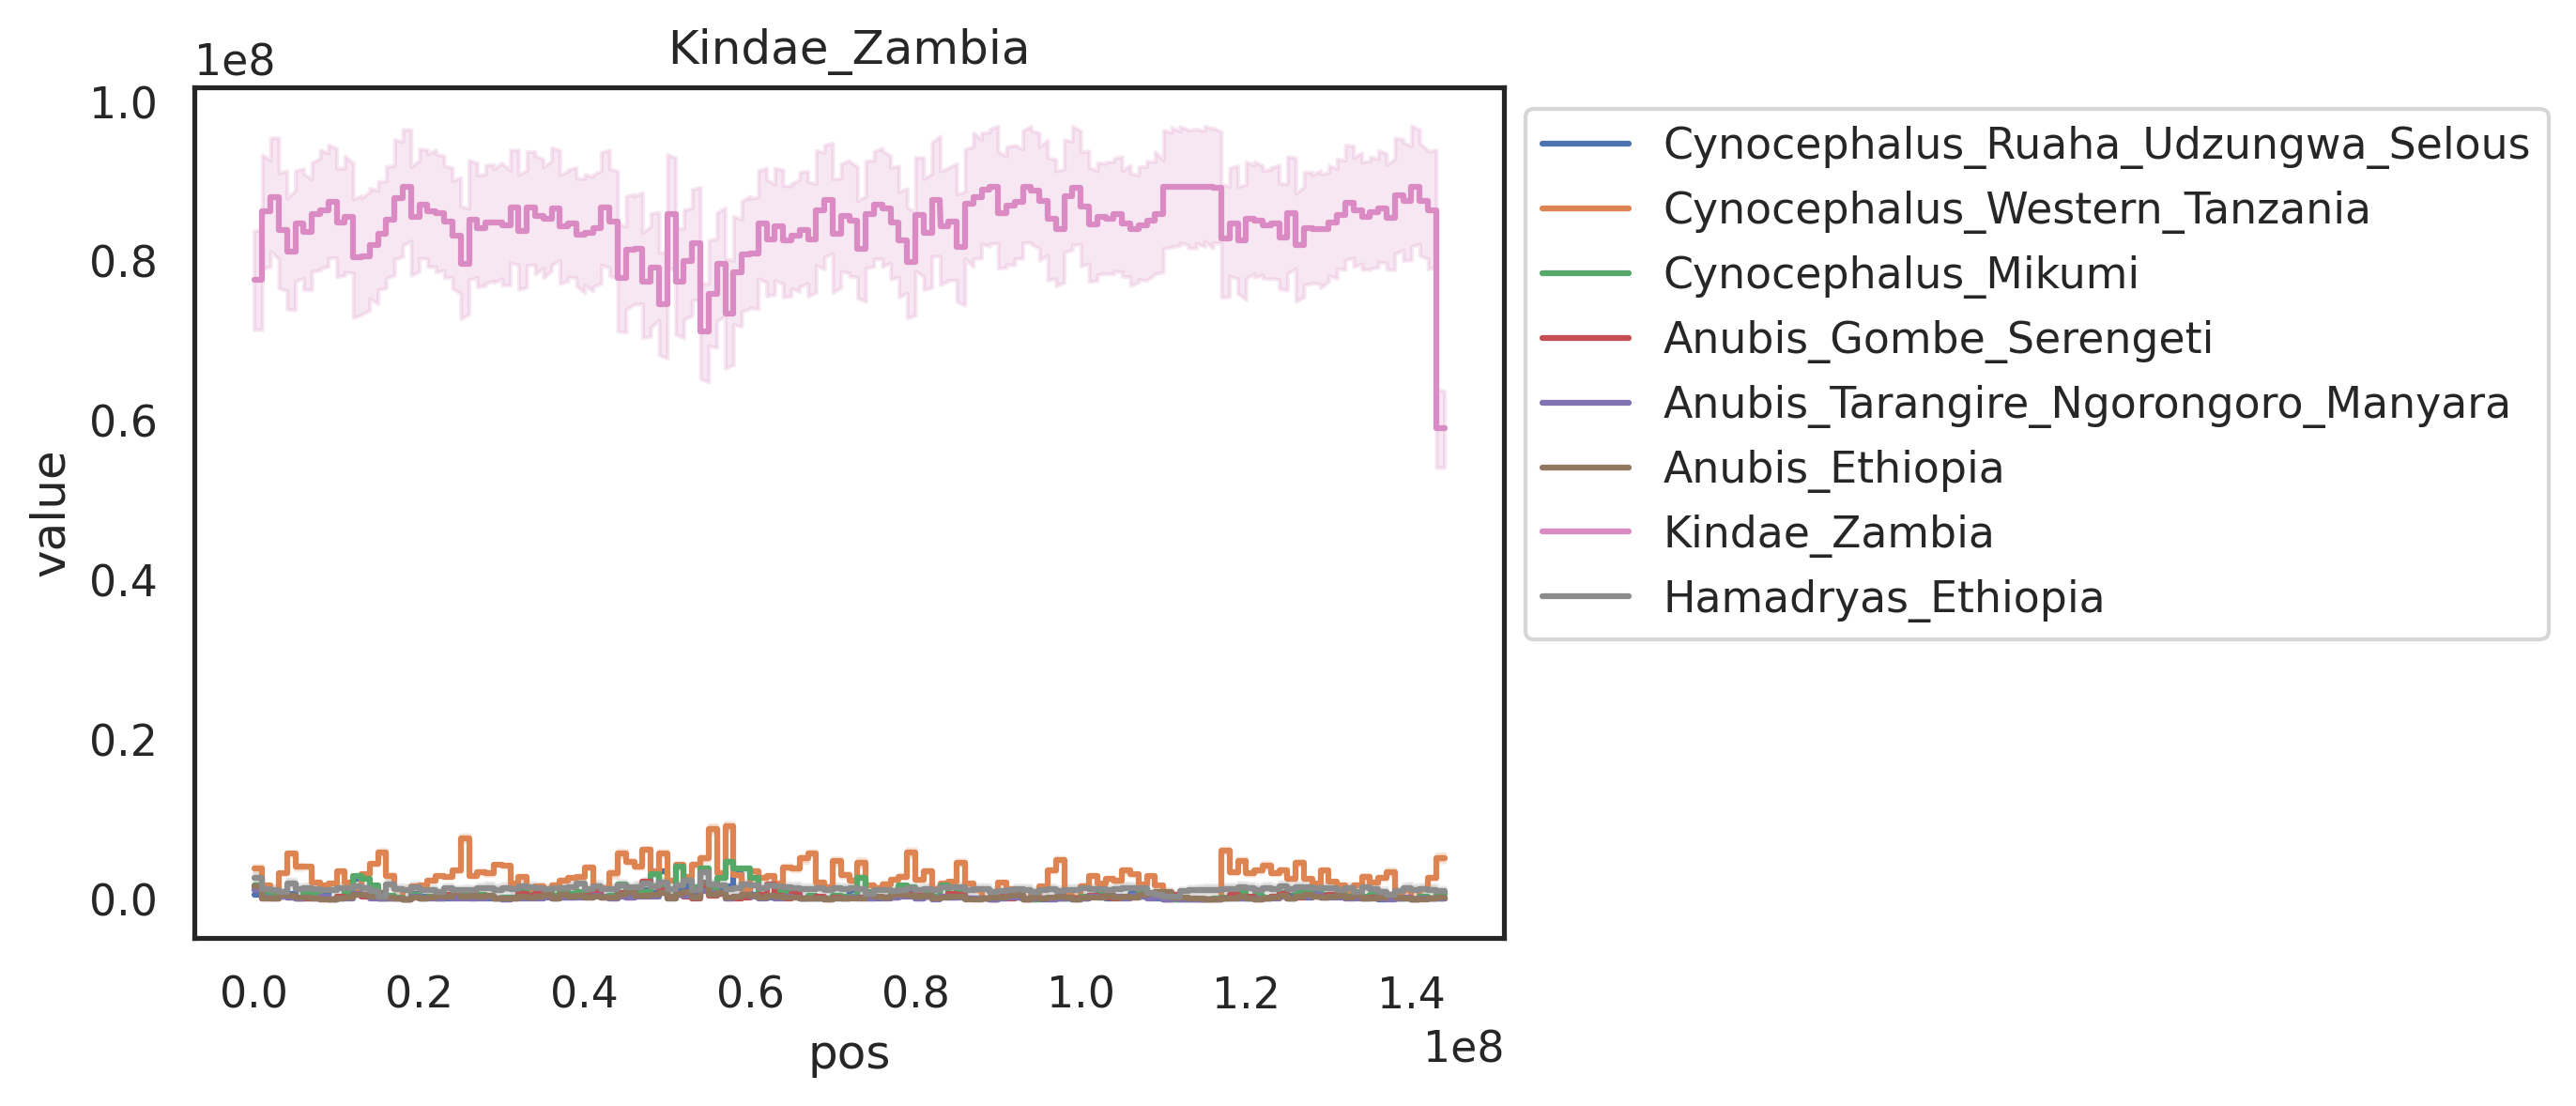

In [46]:
window = 1000000
for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
    if population == "Cynocephalus_Mikumi": #There is a problem with a painting in Mikumi
        continue
    all_df = create_paint_df_group_allcopy(population, window)
    stair_df = stairs(all_df, endtrim=1)
    stair_df = stair_df.drop(columns=["paint", "individual", "start", "end"])
    stair_df = pd.melt(stair_df, id_vars="pos")
    plt.figure()
    g = sns.lineplot(data=stair_df, x="pos", y="value", hue="variable")
    g.legend(bbox_to_anchor=(1,1))
    g.set(title=population)
    plt.savefig("../results/group_painting_all_copy_{}".format(population), transparent=True, bbox_inches="tight")

Picking out single individuals to plot

In [7]:
idfile.loc[idfile.inclusion==1]["pop"].unique()

array(['Cynocephalus_Ruaha_Udzungwa_Selous',
       'Cynocephalus_Western_Tanzania', 'Cynocephalus_Mikumi',
       'Anubis_Gombe_Serengeti', 'Anubis_Tarangire_Ngorongoro_Manyara',
       'Anubis_Ethiopia', 'Kindae_Zambia', 'Hamadryas_Ethiopia'],
      dtype=object)

2


[Text(0.5, 1.0, 'Kindae_Zambia_ind2')]

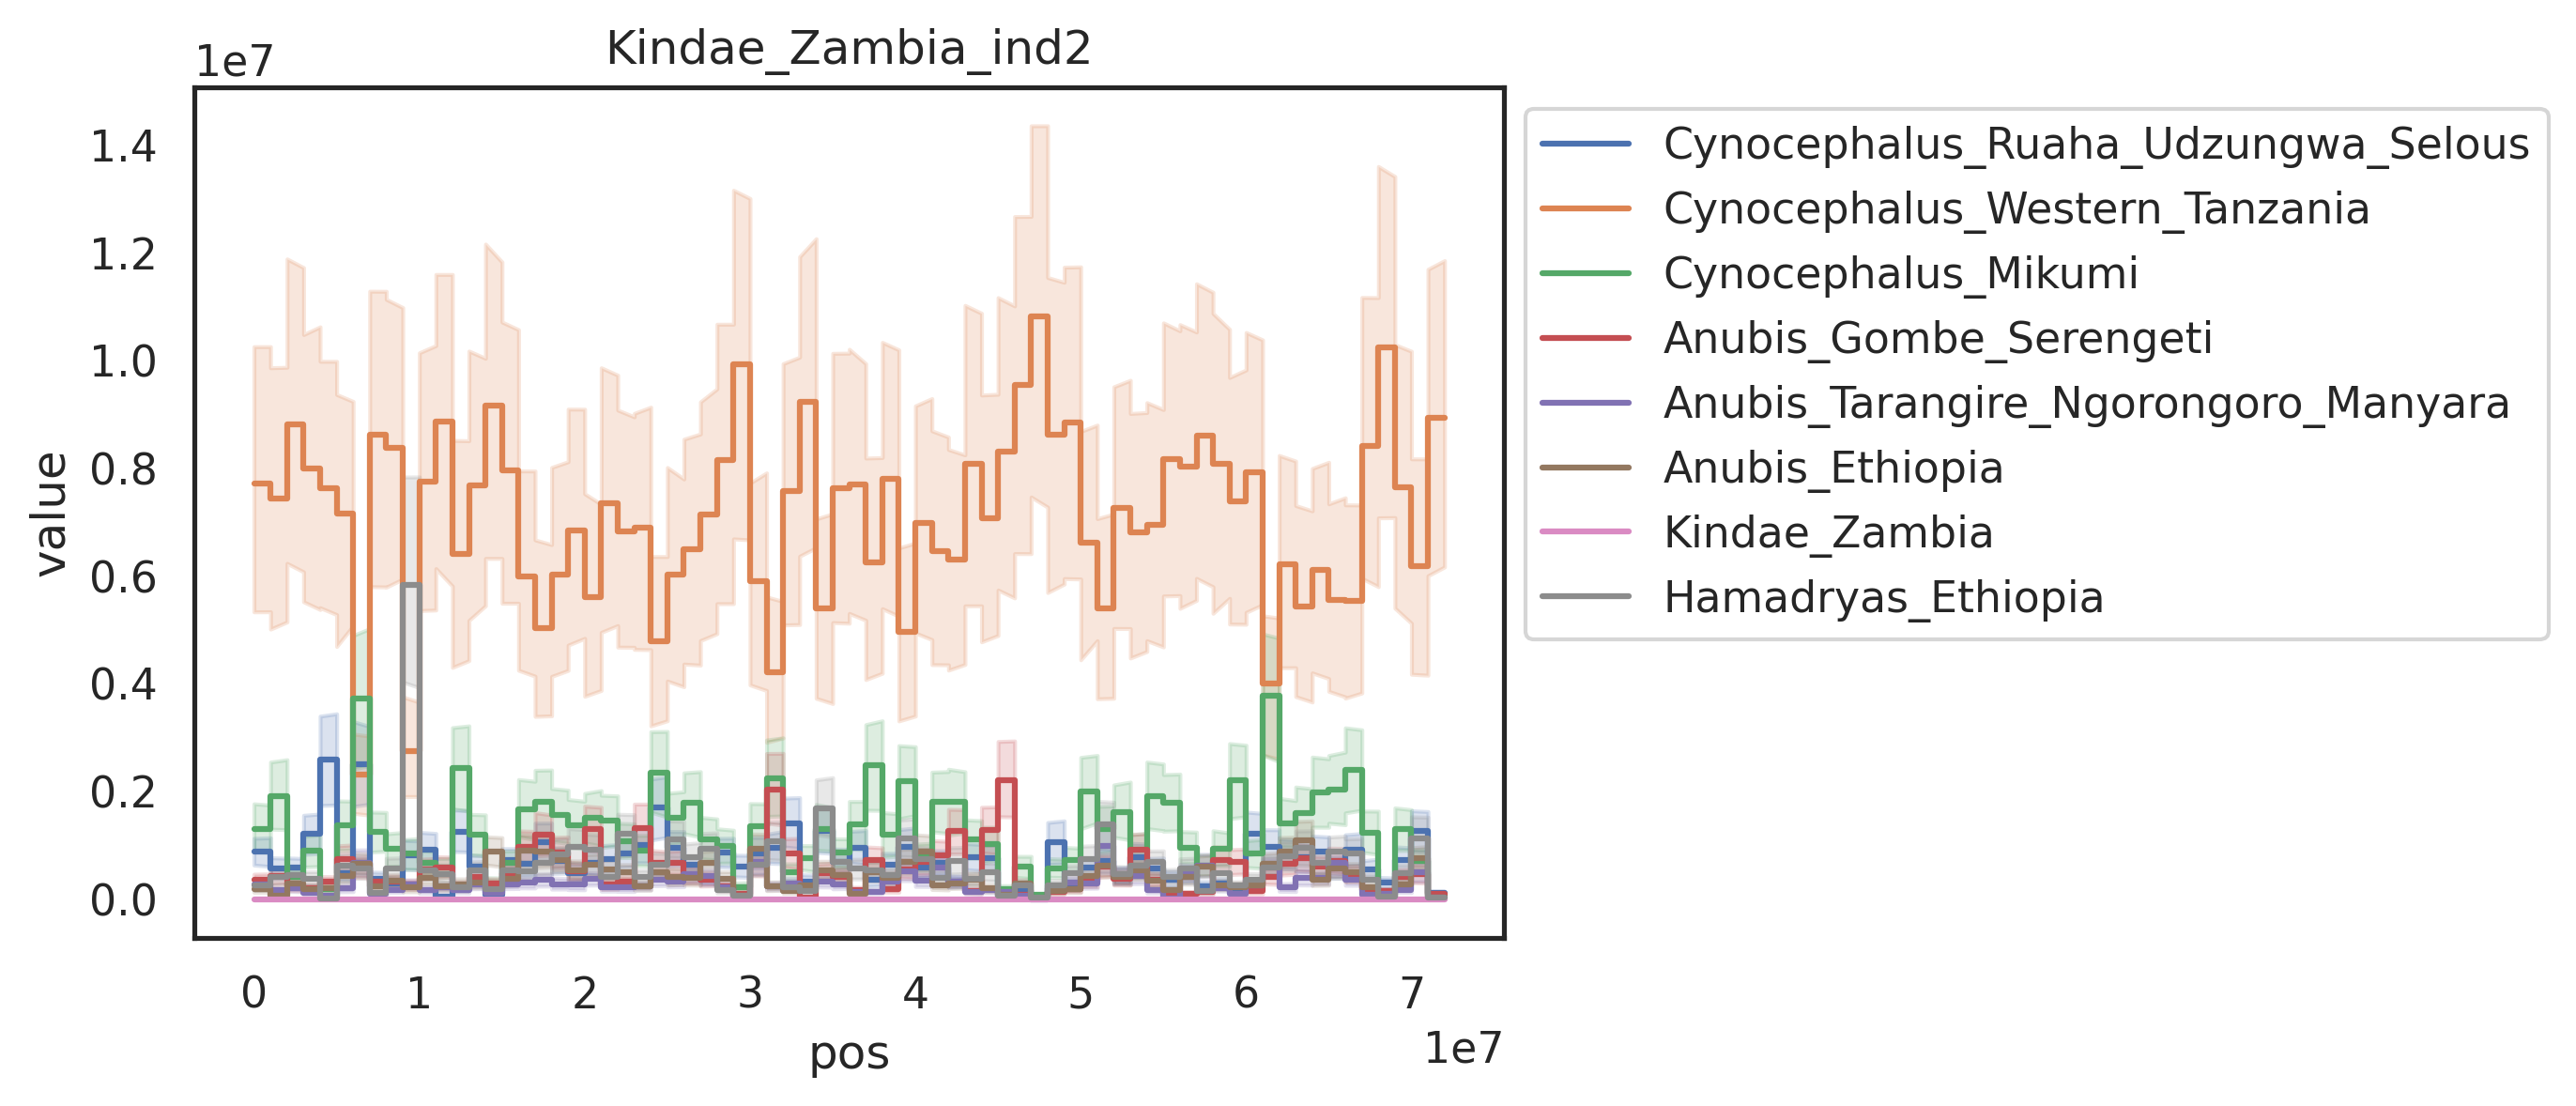

In [26]:
window = 2000000
population = "Anubis_Ethiopia"
ind = 2
all_df = create_paint_df_ind(population, ind, window)
stair_df = stairs(all_df, endtrim=1)
stair_df = stair_df.drop(columns=["paint", "individual", "start", "end"])
stair_df = pd.melt(stair_df, id_vars="pos")
plt.figure()
g = sns.lineplot(data=stair_df, x="pos", y="value", hue="variable")
g.legend(bbox_to_anchor=(1,1))
g.set(title=population+"_ind{}".format(ind))

In [26]:
population = "Anubis_Ethiopia"
ind = 2
all_df = painting_spots(population, ind, window)

2


[None]

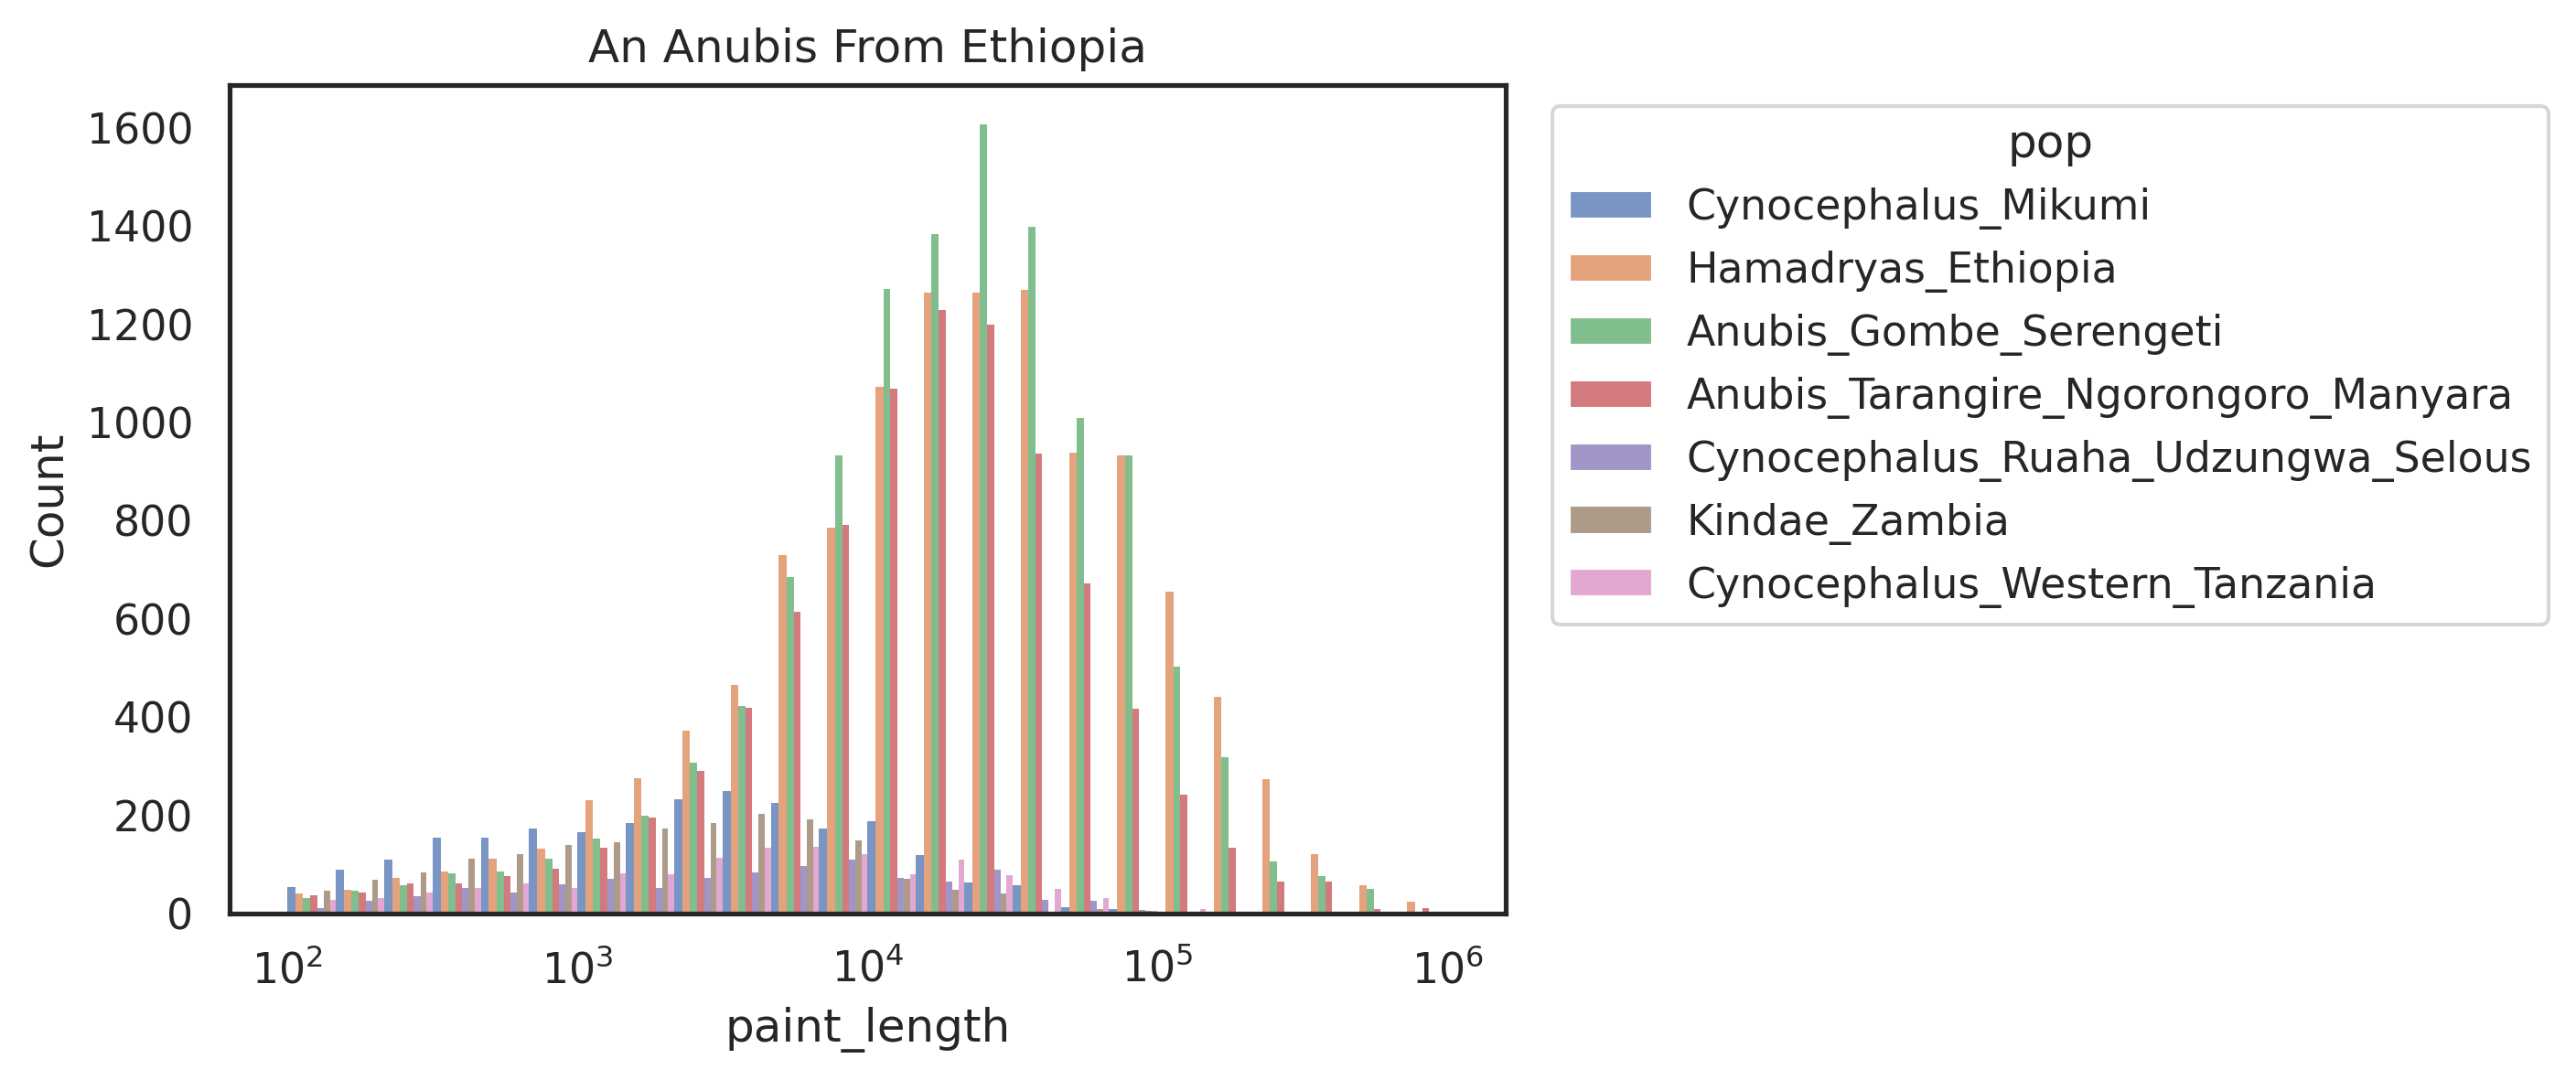

In [27]:
def move_legend(ax, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), title=title, **kws)
    
g = sns.histplot(all_df, x="paint_length", hue="pop", multiple="dodge",
                  bins=np.logspace(np.log10(100),np.log10(1000000), 25))
move_legend(g)
g.set(title="An Anubis From Ethiopia")
g.set(xscale="log")

[Text(0.5, 1.0, 'An Anubis From Ethiopia'), (-100.0, 100000.0)]

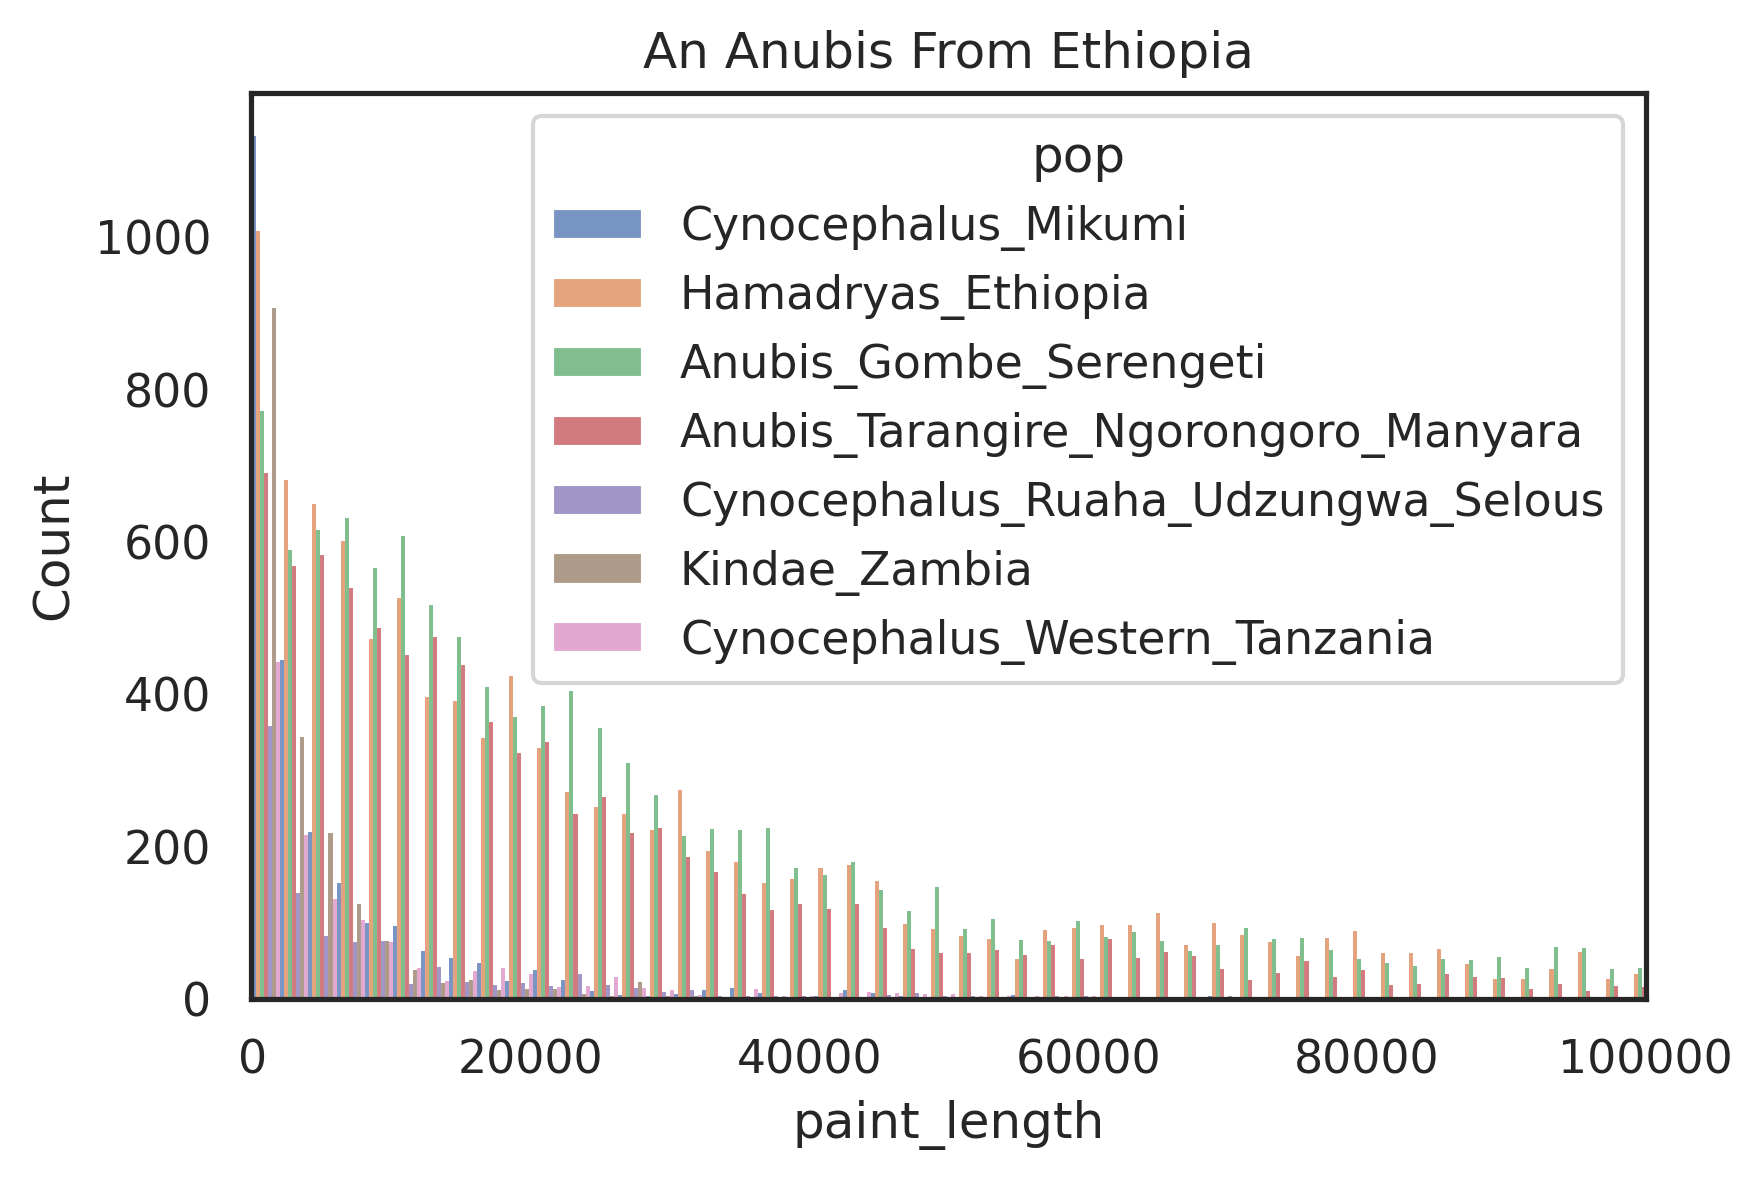

In [23]:
g = sns.histplot(all_df, x="paint_length", hue="pop", multiple="dodge")
#move_legend(g)
g.set(title="An Anubis From Ethiopia", xlim=(-100, 100000))

In [52]:
total_p_l = all_df.paint_length.sum()
hama_paint = all_df.loc[all_df["pop"] == "Hamadryas_Ethiopia"].paint_length.sum()
non_hama_paint = all_df.loc[all_df["pop"] != "Hamadryas_Ethiopia"].paint_length.sum()
anubis_paint = all_df.loc[(all_df["pop"] == "Anubis_Gombe_Serengeti") | (all_df["pop"] == "Anubis_Tarangire_Ngorongoro_Manyara")].paint_length.sum()

In [53]:
hama_paint/total_p_l, anubis_paint/total_p_l

(0.42341415748336003, 0.545145799764302)

In [56]:
df_long_fragments = all_df.loc[all_df.paint_length > 100000]
total_p_l = df_long_fragments.paint_length.sum()
hama_paint = df_long_fragments.loc[df_long_fragments["pop"] == "Hamadryas_Ethiopia"].paint_length.sum()
non_hama_paint = df_long_fragments.loc[df_long_fragments["pop"] != "Hamadryas_Ethiopia"].paint_length.sum()
anubis_paint = df_long_fragments.loc[(df_long_fragments["pop"] == "Anubis_Gombe_Serengeti") |
                                            (df_long_fragments["pop"] == "Anubis_Tarangire_Ngorongoro_Manyara")].paint_length.sum()

In [57]:
hama_paint/total_p_l, anubis_paint/total_p_l

(0.5258999093000265, 0.4725295665321015)

In [48]:
all_df.loc[all_df["pop"] == "Hamadryas_Ethiopia"].paint_length.sum()

608399501

Allowing copying inpop

In [29]:
all_df = painting_spots_allcopy("Anubis_Ethiopia", window)

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


[None]

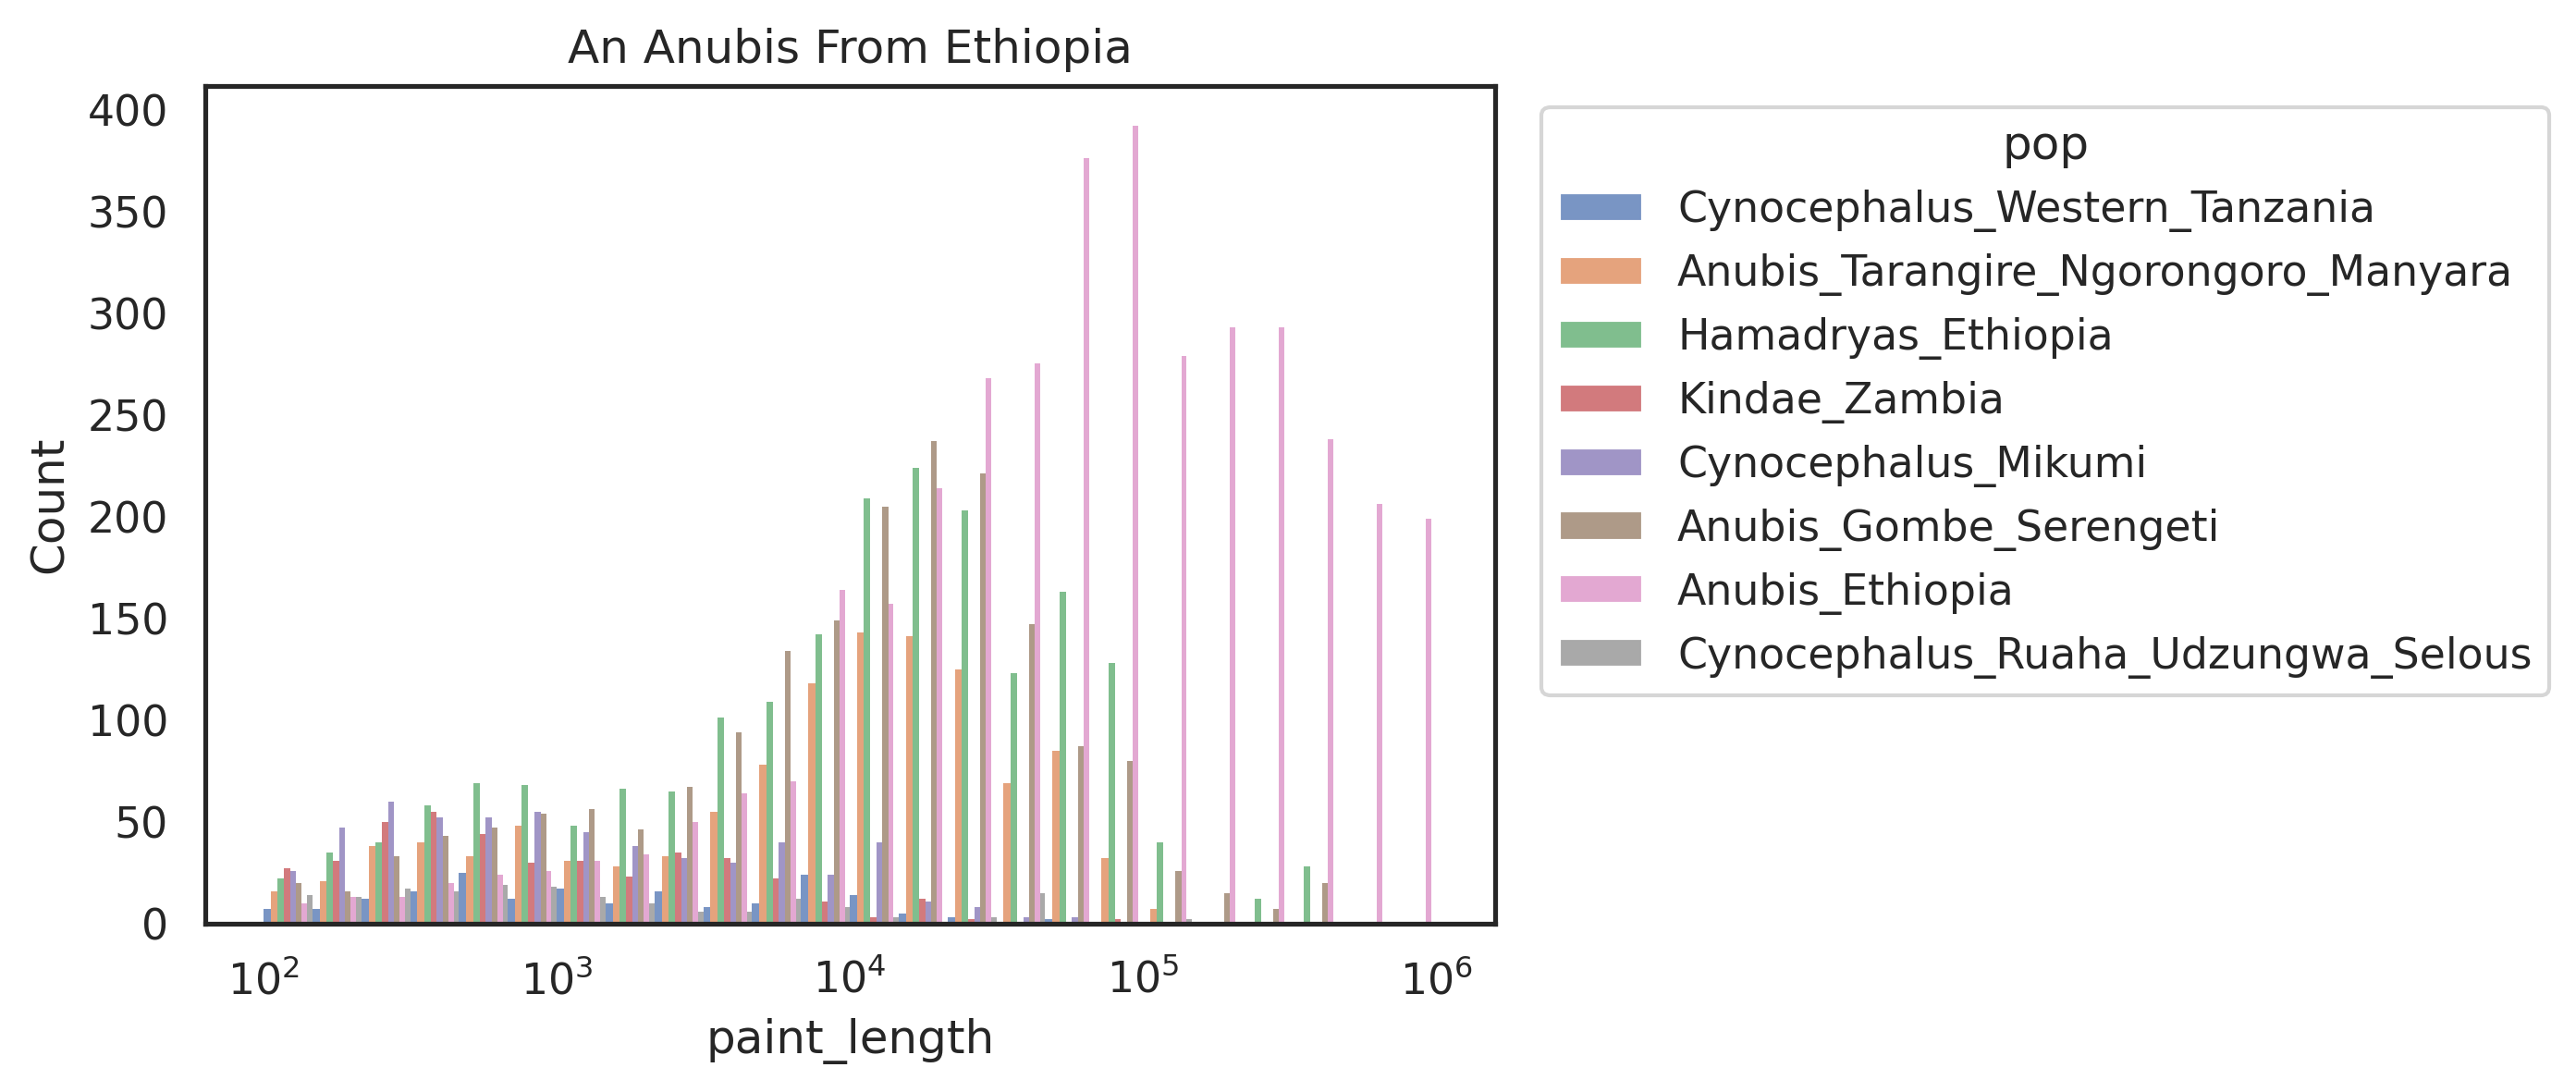

In [32]:
single_ind = all_df.loc[all_df.individual==65]
g = sns.histplot(single_ind, x="paint_length", hue="pop", multiple="dodge",
                  bins=np.logspace(np.log10(100),np.log10(1000000), 25))
move_legend(g)
g.set(title="An Anubis From Ethiopia")
g.set(xscale="log")

[Text(0.5, 1.0, 'Anubis from Tarangire, Ngorongoro, Manyara')]

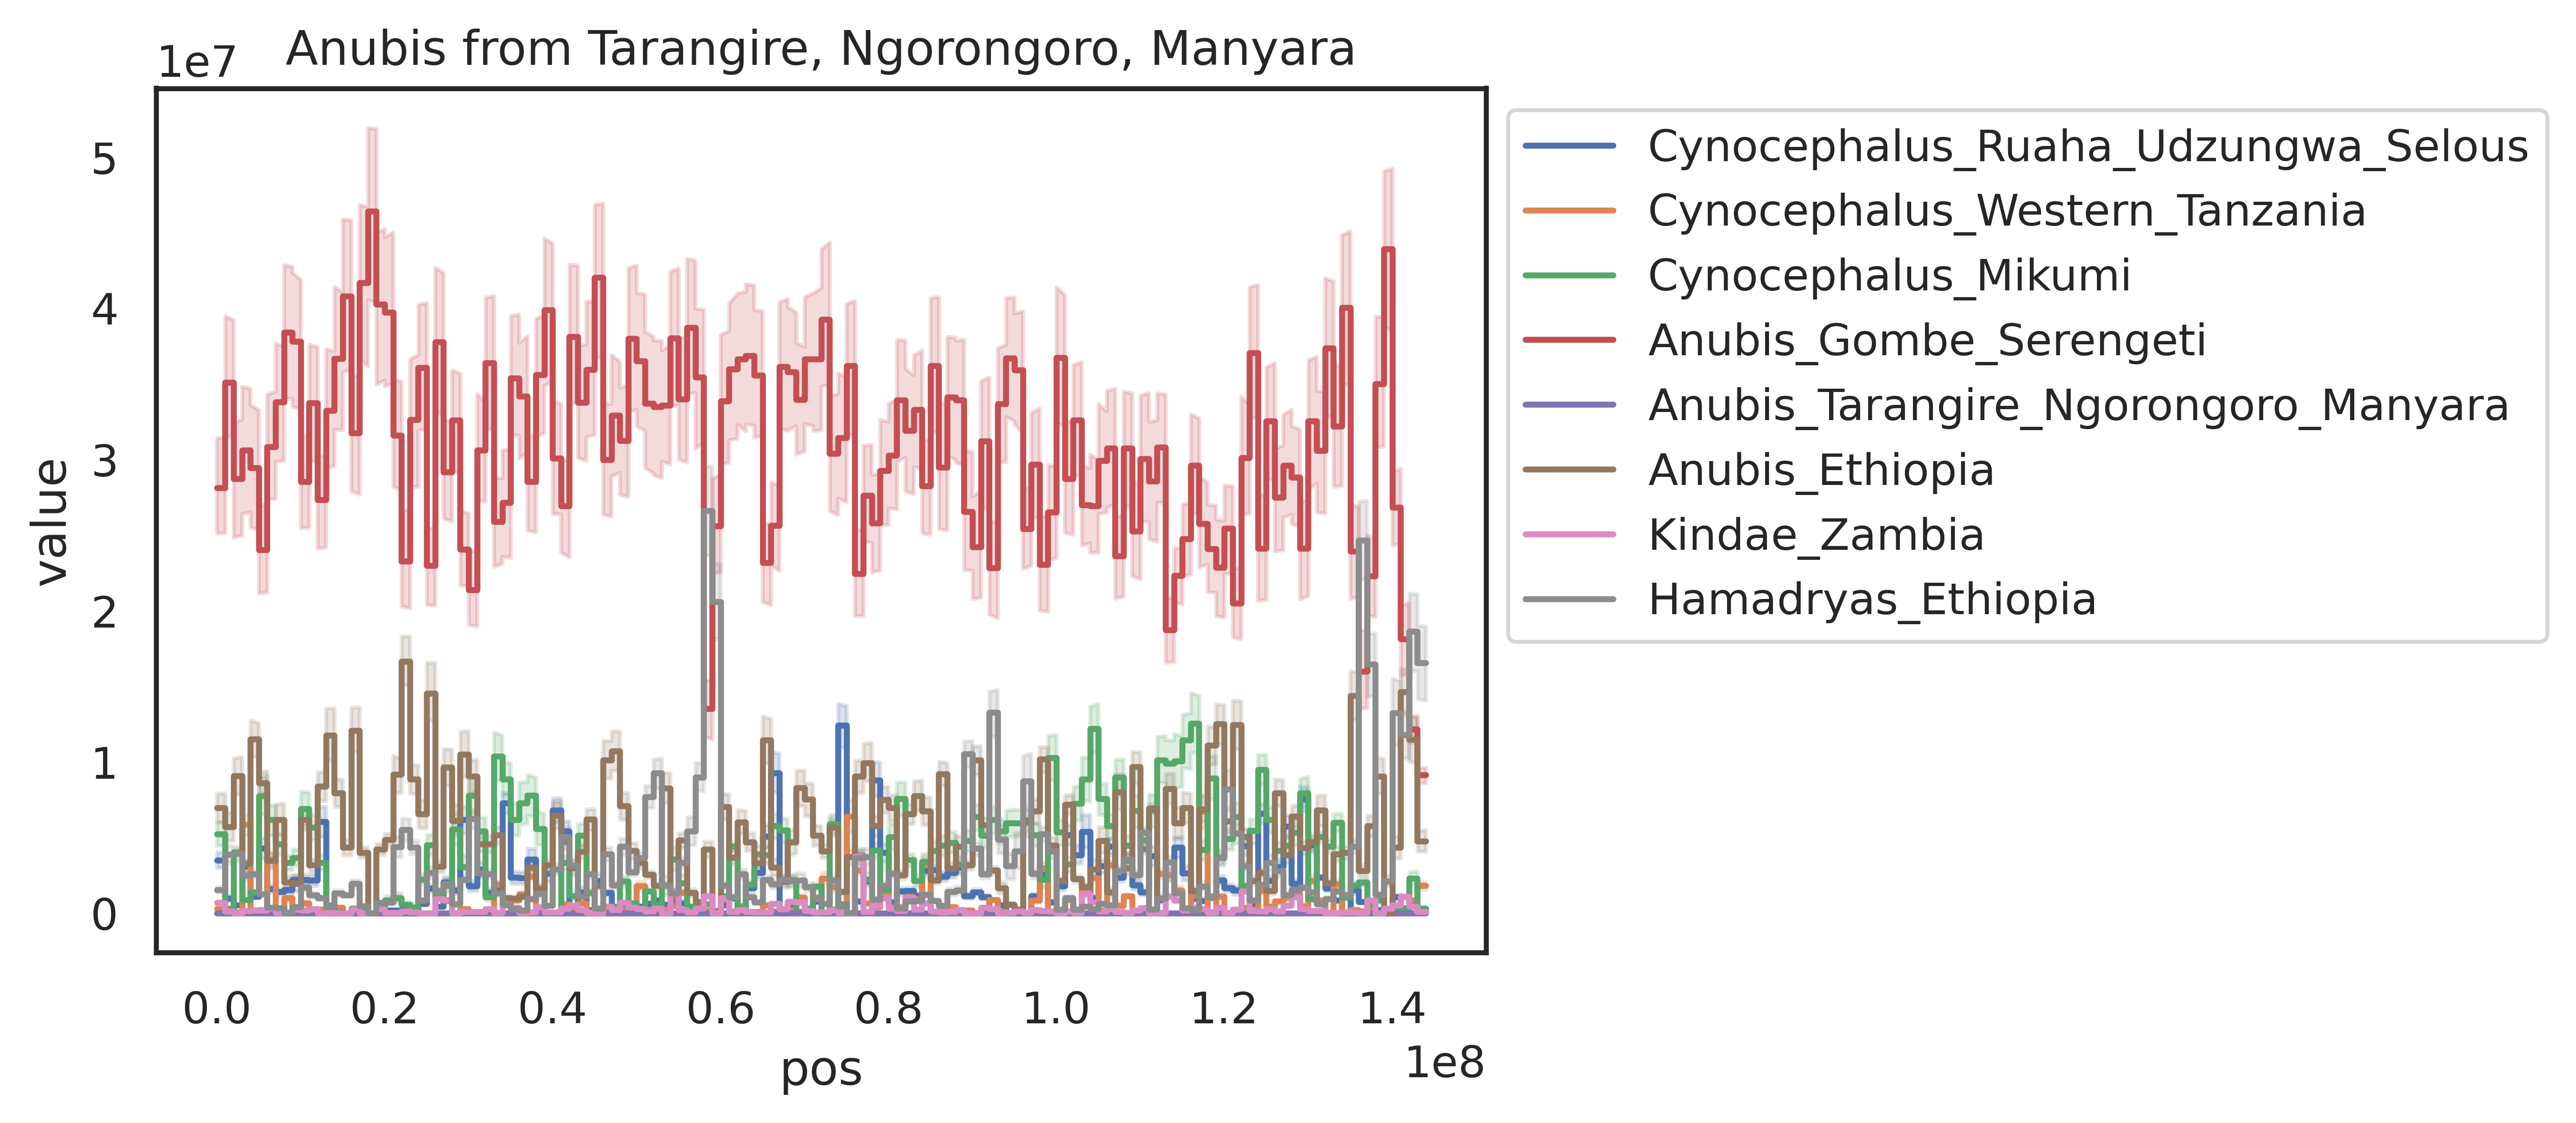

In [82]:
g = sns.lineplot(data=stair_df, x="pos", y="value", hue="variable")
g.legend(bbox_to_anchor=(1,1))
g.set(title="Anubis from Tarangire, Ngorongoro, Manyara")

In [107]:
all_df = create_paint_df("Cynocephalus_Western_Tanzania", window)

0
1
2
3
4
5
6


In [108]:
stair_df = stairs(all_df, endtrim=1)
stair_df = stair_df.drop(columns=["paint", "individual", "start", "end"])
stair_df = pd.melt(stair_df, id_vars="pos")

[Text(0.5, 1.0, 'Cynocephalus from Western Tanzania')]

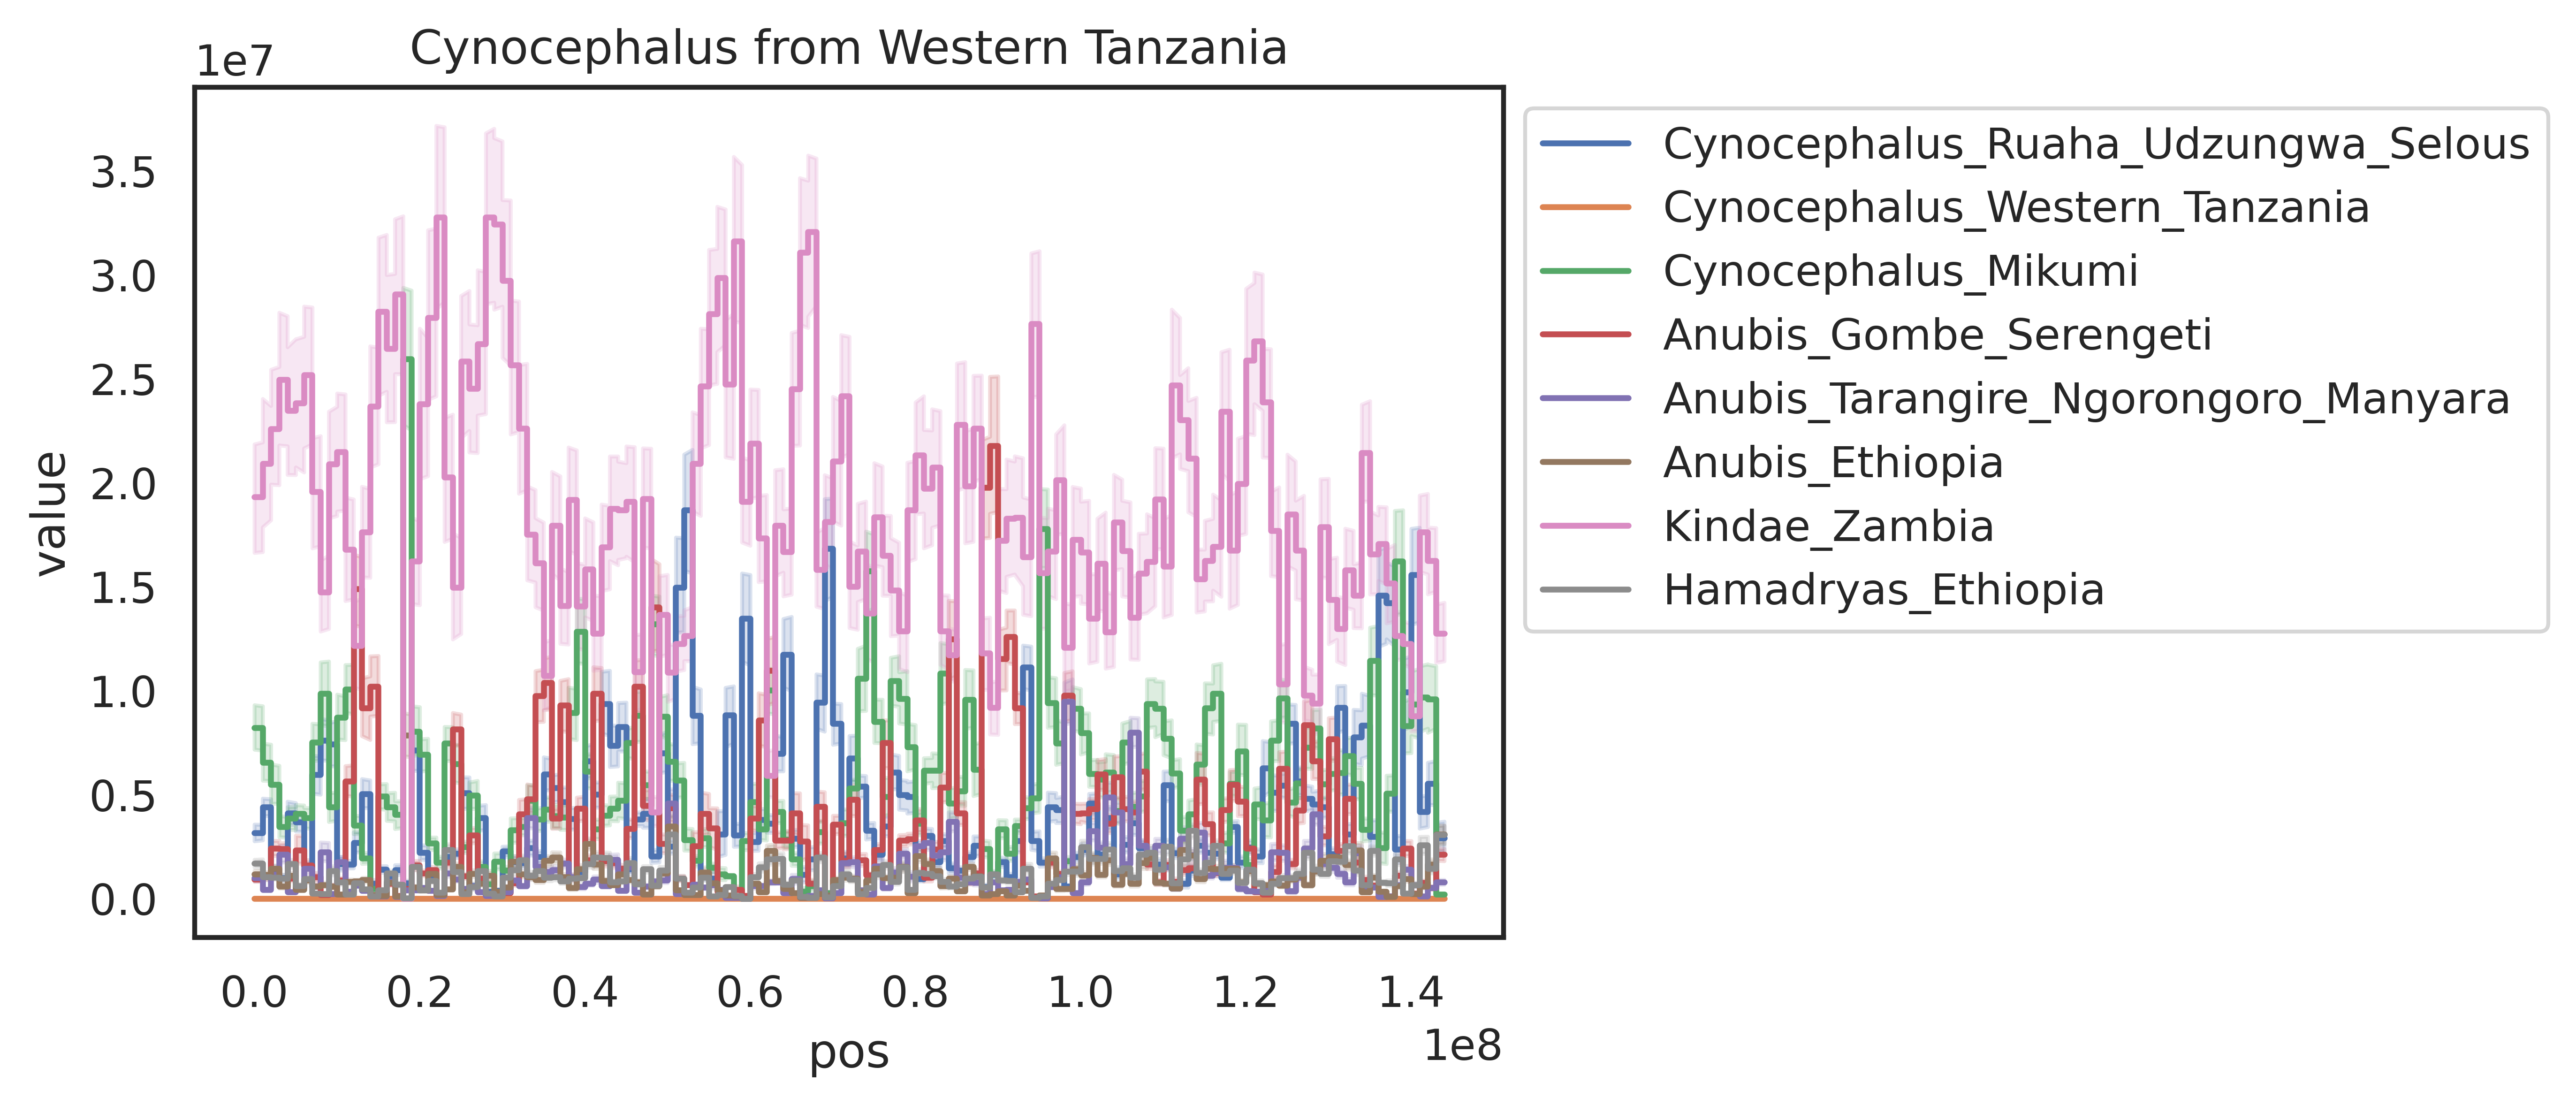

In [109]:
g = sns.lineplot(data=stair_df, x="pos", y="value", hue="variable")
g.legend(bbox_to_anchor=(1,1))
g.set(title="Cynocephalus from Western Tanzania")

In [ ]:
#When iterating through the data that allows all non-self copying
all_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/chromopaintings/copy{}.samples.out"
for i, row in (idfile.loc[idfile["pop"] == pop_inv]).iterrows():
    f = open(all_donor.format(row.ID_index-1), "r")
    ad_lines = f.readlines()
    print(i)
    for p_num in range(10):
        paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
        single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
        single_p_df = single_p_df.astype(int)
        spot_df = generate_spot_df(single_p_df, map_dict)
        pop_dict = count_paint_windows(pop_dict, spot_df, window)
paintings_df_all_donor = pd.DataFrame(data=pop_dict)

In [ ]:
g = paintings_df_all_donor.plot.area().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [ ]:
x_index = range(end_pos//window+1)
l_l = []
label_l = []
for key in pop_dict:
    l_l.append(pop_dict[key])
    label_l.append(key)
l_l = np.array(l_l)

In [ ]:
plt.stackplot(x_index, l_l, labels=label_l)
plt.legend(bbox_to_anchor = [1.85, 1.03])

Old code to test and create the implementation shown above

In [ ]:
f = open(no_inpop_donor, "r")
ad_lines = f.readlines()
ad_lines[1]

In [ ]:
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile.loc[idfile["pop"] == "Anubis_Tarangire_Ngorongoro_Manyara"]

In [ ]:
idfile["pop"].unique()

In [ ]:
idfile["ID_index"] = idfile.index+1

In [ ]:
map_dict = {}
for i, row in idfile.iterrows():
    map_dict[row.ID_index] = row["pop"]

In [ ]:
recomb_map = pd.read_csv(recomb_map_path, sep=" ")
pos_list = recomb_map["start.pos"]

In [ ]:
paint_line = ad_lines[2].strip().split(" ")[1:]

Creating a dataframe containing a single painting sample.
Note: Positions correspond to index in idfile+1

In [ ]:
single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
single_p_df = single_p_df.astype(int)

In [ ]:
single_p_df["paint"].values.max(), len(idfile)
#P. Papio is not included, and are the last

In [ ]:
single_p_df["pop"] = single_p_df["paint"].map(map_dict)

Calculating position/lengths of runs by finding the rows in which it changes.

In [ ]:
#Boolean which is true when the value changes
shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
#df based on this subset
spot_df = single_p_df.loc[shift_spots]
#Finding the start of the next painting, by removing the first pos and adding the last snp.
#And then calculating the difference.
spot_df["paint_length"] = np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values
spot_df["end_pos"] = np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1

In [ ]:
g = sns.FacetGrid(data=spot_df, col="pop")
g.map(sns.histplot, "paint_length")

Testing a stackplot

In [ ]:
x=range(1,4)
y = [[0.4, 0.9, 0.2], [0.6, 0.1, 0.8]]
plt.stackplot(x,y, labels=["Cyno", "Anubis"])
plt.legend(loc='upper left')